<a href="https://colab.research.google.com/github/juandmantilla/Prediccion-LQI-RSSI-series-de-tiempo/blob/master/Experimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXPERIMENTOS AUTOMATIZADOS

En este notebook se tratará de automatizar los procesos para la evaluación de los algoritmos de RF, SVM ARIMA y LSTM.


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------- Carga de Modelos ----------------------
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima_model import ARIMA
from sklearn.svm import SVR
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential

from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# ----------------------------------------------------------------------




#Definición de métodos para carga de datos
def cargarDatos(direccion, nodeId, SrcNode):
    nodos = pd.read_csv(direccion)
    nodo1 = nodos.loc[nodos['NodeId'] == nodeId]
    nodo1 = nodo1.loc[nodo1['SrcNodeId'] == SrcNode ]

    #Devuelve un dataframe
    return nodo1


def diferenciarSerie(datos, indicador):
    a = datos[[indicador]].diff(periods = 1).values
    a[0] = a[1]
    fecha = datos[["Date"]].values
    
    b = np.concatenate((fecha, a), axis = 1)
    
    datos = pd.DataFrame(data = b, columns=["Date", indicador])
    
    #Cambio de valores con 0 para evitar indeterminaciones
    datos.loc[datos[indicador] == 0, indicador] = 0.5
    return datos
  


def promediarSerie(datos, indicador):
    datos = datos.rolling(1).mean()
    datos[indicador].fillna(0.5, inplace = True)
    return datos
    

def unPaso(datos, indicador):    
    dataX = np.array([])
    dataY = np.array([])
    
    for i in range(len(datos.values)):
        dataX = np.append(dataX, datos[[indicador]].values[i-1])
        dataY = np.append(dataY, datos[[indicador]].values[i])
    
    dataX[0] = 0
    
    return dataX, dataY


def multiplesPasos(datos, indicador, pasos):
    a = np.array([])
    for i in datos[[indicador]].values:
        a = np.append(a, i[0])
  
      # Se implementa el Time Delay Embedding. Que es una ténica para obtener los valores t - n hacia atrás de un
      # valor LQI en el tiempo t. Esta función recibe el parámetro w que indica la cantidad de pasos hacia atrás que se
      #tendrán en cuenta y el parámetro g define la cantidad de pasos para una observación en un tiempo t + g


    w = pasos + 1  #----> Cantidad de observaciones que se tienen en cuenta para definir la observación en tiempo t más uno

    g = 1  # ---> Si una observación está en el tiempo t, esta define la siguiente observación en tiempo t + g

    dataTransform = a[(np.arange(w)*(g))+ np.arange(np.max(a.shape[0] - (w-1)*(g), 0)).reshape(-1,1)]
    dataTransform = np.array(dataTransform)
    
    
    return dataTransform[:, :-1], dataTransform[:, -1]

def multiplesPasosLSTM(datos, indicador, pasos):
    a = np.array([])
    for i in datos[[indicador]].values:
        a = np.append(a, i[0])
  
      # Se implementa el Time Delay Embedding. Que es una ténica para obtener los valores t - n hacia atrás de un
      # valor LQI en el tiempo t. Esta función recibe el parámetro w que indica la cantidad de pasos hacia atrás que se
      #tendrán en cuenta y el parámetro g define la cantidad de pasos para una observación en un tiempo t + g


    w = pasos*2  #----> Cantidad de observaciones que se tienen en cuenta para definir la observación en tiempo t más uno

    g = 1  # ---> Si una observación está en el tiempo t, esta define la siguiente observación en tiempo t + g

    dataTransform = a[(np.arange(w)*(g))+ np.arange(np.max(a.shape[0] - (w-1)*(g), 0)).reshape(-1,1)]
    dataTransform = np.array(dataTransform)
    
        
    return dataTransform[:, :-pasos], dataTransform[:, -pasos:]


#---------------------------------------------DEFINICIÓN DE MODELOS ------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------

def modeloRF(dataX, dataY, pasos, diferenciada, datosOriginales, indicador):
  # Generando el conjunto de datos. 80% de entrenamiento. Recuerde que shuffle indica que los valores
  # no se muevan aleatoriamente en el conjunto de datos
  fc = 0
  x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=0.4,shuffle= False)

  random = RandomForestRegressor(n_estimators=300, oob_score= True)
    
  pred = 0
    
  #Con 1 paso y no diferenciada
  if(pasos == 1 and diferenciada == False):
    random = random.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
    pred = random.predict(x_test.reshape(-1, 1))
        
  #Con pasos y no diferenciada
  elif(pasos > 1 and diferenciada == False):
    random = random.fit(x_train, y_train)
    pred = random.predict(x_test)
        
        
  #Con 1 paso y diferenciada
  elif(pasos == 1 and diferenciada == True):
    random = random.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
    pred = random.predict(x_test.reshape(-1, 1))
        
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[x_train.shape[0] -1 + i]
      b = np.append(b, a) 
        
    c = pred.shape[0] 
    y_test = datosOriginales[indicador].values[x_train.shape[0]: x_train.shape[0] + c ]
    pred = b
    
  #Con pasos y diferenciada
  elif((pasos > 1) and diferenciada == True):
  #Suma de numeros de filas y columnas para el desplazamiento
    fc = x_train.shape[0] + x_train.shape[1]
        
    random = random.fit(x_train, y_train)
    pred = random.predict(x_test)
        
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc  + i ]
      b = np.append(b, a) 
        
    c = pred.shape[0] 
    y_test = datosOriginales[indicador].values[fc  : fc + c ]
    pred = b

  return y_test, pred, y_train



def modeloSVM(dataX, dataY, pasos, diferenciada, datosOriginales, indicador):
  x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=0.4, shuffle= False)
  svr = SVR()
  pred = 0
  fc = 0
  #Con 1 paso y no diferenciada
  if(pasos == 1 and diferenciada == False):
    svr = svr.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
    pred = svr.predict(x_test.reshape(-1, 1))
        
  #Con pasos y no diferenciada
  elif(pasos > 1 and diferenciada == False):
    svr = svr.fit(x_train, y_train)
    pred = svr.predict(x_test)
        
  #Con 1 paso y diferenciada
  elif(pasos == 1 and diferenciada == True):
    svr = svr.fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1))
    pred = svr.predict(x_test.reshape(-1, 1))
        
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):  
      a = pred[i] + datosOriginales[indicador].values[x_train.shape[0] -1 + i]
      b = np.append(b, a) 
        
    c = pred.shape[0] 
    y_test = datosOriginales[indicador].values[x_train.shape[0]: x_train.shape[0] + c ]
    pred = b
    
  #Con pasos y diferenciada
  elif(pasos > 1 and diferenciada == True):
    fc = x_train.shape[0] +x_train.shape[1]
    svr = svr.fit(x_train, y_train)
    pred = svr.predict(x_test)
        
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc  + i ]
      b = np.append(b, a) 
        
    c = pred.shape[0] 
    y_test = datosOriginales[indicador].values[fc  : fc + c ]
    pred = b

  return y_test, pred, y_train


def modeloArima(datos, pasosTemp ,pasosDif ,indicador):
    
    datos = datos[[indicador]].values
    datos = datos.astype("float32")
    
    #Creando conjunto de entrenamiento y prueba
    num = int(len(datos)*0.6)

    entrenamiento, prueba = datos[:num], datos[num:]

    # Como por cada observación y posterior proyección se debe analizar observaciones anteriores, entonces se debe
    # entrenar el modelo para cada observacion proyectada

    #copia de entrenamiento. Ese arreglo guarda valores nuevos del arreglo de prueba.
    #Para garantizar que el modelo ARIMA se entrene con los valores posteriores a las observaciones de entrenamiento
    h = [i for i in entrenamiento]

    predicciones = []

    #por cada observación de prueba se genera la proyección con respecto a las observaciones de test
    for i in range(len(prueba)):

        # --> Recuerde los parámetros de ARIMA.
        modeloArima = ARIMA(h, order=(pasosTemp, pasosDif, 0))
        modeloEntrenado = modeloArima.fit(disp = 0)

        # Predicción de observación para la observación t+1 de entrenamiento
        salida = modeloEntrenado.forecast()

        predTime = salida[0]
        predicciones.append(predTime)

        #Obteniendo valor real de la observación en tiempo t+1
        obs = prueba[i]

        #Añadiendo al vector para que se entrene nuevamente con este valor en el siguiente paso
        h.append(obs)

    return prueba, predicciones, num


#Función para arreglos unidimensionales
def cambiarEscala(dataX, dataY, pasos):
  if(pasos == 1):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(dataX.reshape(-1, 1))


    dataX = dataX.reshape(-1, 1)
    dataX = scaler.transform(dataX)

    dataY = dataY.reshape(-1, 1)
    dataY = scaler.transform(dataY)
    
    scaler2 = 0

  elif(pasos > 1):

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(dataX)

    scaler2 = MinMaxScaler(feature_range=(0, 1))
    scaler2 = scaler2.fit(dataY.reshape(-1, 1))

    dataX = scaler.transform(dataX)
    dataY = scaler2.transform(dataY.reshape(-1, 1))

  return dataX, dataY, scaler, scaler2

def cambiarEscala_LSTM(dataX, dataY):
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = scaler.fit(dataX)

  dataX = scaler.transform(dataX)
  dataY = scaler.transform(dataY)

  return dataX, dataY, scaler


def invertirEscala(scaler, datos):
    datos = scaler.inverse_transform(datos)
    return datos


def prediccionLSTM(modelo, batch_size, x_test, pasos):
  if(pasos == 1):
    x_test = x_test.reshape((1, 1, x_test.shape[0]))
    pred = modelo.predict(x_test, batch_size = batch_size)

  elif(pasos > 1):
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
    pred = modelo.predict(x_test, batch_size = batch_size)
    
  return pred

# -------------------------------------- MODELO LSTM  ----------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------

def modeloLSTM(dataX, dataY, pasos, diferenciada, datosOriginales, indicador,
              numNeuronas, batch_size, numEpoc):
  fc = 0
  pred = np.array([])
  y_test = np.array([])

  # 1 pasos sin diferenciar ----------------------------------------------------
  if((pasos == 1) and diferenciada == False):

    # Generando el conjunto de datos. 80% de entrenamiento. Recuerde que shuffle indica que los valores
    # no se muevan aleatoriamente en el conjunto de datos
    dataX, dataY,scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=0.4,shuffle= False)

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
        
    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    #Invertir escala de datos
    trainPredict = invertirEscala(scaler, trainPredict)
    trainY = invertirEscala(scaler, y_train)
    pred = invertirEscala(scaler, testPredict)
    y_test = invertirEscala(scaler, y_test)

    # Preparar datos de entrenamiento y prueba para más pasos.

  # Pasos sin diferenciar ----------------------------------------------------------------------------
  elif((pasos > 1) and diferenciada == False):
    dataX, dataY, scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=0.4,shuffle= False)

    fc = x_train.shape[0] + x_train.shape[1] 

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    print(model.summary())

    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    print(trainPredict.shape)
    print(testPredict.shape)

    #Invertir escala de datos
    trainPredict = invertirEscala(scaler2, trainPredict)
    trainY = invertirEscala(scaler2, y_train)

    pred = invertirEscala(scaler2, testPredict)
    y_test = invertirEscala(scaler2, y_test)
    

  # 1 paso y diferenciada ---------------------------------------------------------------------------
  elif((pasos == 1) and diferenciada == True):
    dataX, dataY,scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=0.4,shuffle= False)

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
        
    

    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    #Invertir escala de datos
    trainPredict = invertirEscala(scaler, trainPredict)
    trainY = invertirEscala(scaler, y_train)
    pred = invertirEscala(scaler, testPredict)
    y_test = invertirEscala(scaler, y_test)

    
    #Transformar datos para el dominio original
    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[x_train.shape[0] -1 + i]
      b = np.append(b, a) 
        
    c = pred.shape[0] 
    y_test = datosOriginales[indicador].values[x_train.shape[0]: x_train.shape[0] + c ]
    pred = b

  # Pasos y diferenciada --------------------------------------------------------------------
  elif((pasos > 1) and diferenciada == True):

    dataX, dataY, scaler, scaler2 = cambiarEscala(dataX, dataY, pasos)
    x_train, x_test, y_train, y_test  = train_test_split(dataX, dataY, test_size=0.4,shuffle= False)

    fc = x_train.shape[0] + x_train.shape[1] 

    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    #Definición de red LSTM
    model = Sequential()
    model.add(LSTM(numNeuronas, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    print(model.summary())

    model.fit(x_train, y_train, epochs=numEpoc, batch_size=batch_size, verbose=0)

    # Hacer predicciones
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)

    print(trainPredict.shape)
    print(testPredict.shape)

    #Invertir escala de datos
    trainPredict = invertirEscala(scaler2, trainPredict)
    trainY = invertirEscala(scaler2, y_train)

    pred = invertirEscala(scaler2, testPredict)
    y_test = invertirEscala(scaler2, y_test)
    

    a = np.array([])
    b = np.array([])
    for i in range(len(pred)):
      a = pred[i] + datosOriginales[indicador].values[fc  + i ]
      b = np.append(b, a) 
        
    c = pred.shape[0] 
    y_test = datosOriginales[indicador].values[fc  : fc + c ]
    pred = b

  return y_test, pred, y_train





#---------------------------------------ERRORES---------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------

def errores(y_test, pred):
    #errorR = round (r2_score(y_test.reshape(-1, 1), pred), 4)
    errorCuadratico = round(mean_squared_error( y_test.reshape(-1, 1) , pred), 4)
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    errorMedio = round( mean_absolute_percentage_error(y_test, pred) , 4)
    
    return errorCuadratico, errorMedio

# Cálculo de errores para más pasos. 
def errores_LSTM(y_test, pred):
  
  errorCuadratico = np.array([])
  if (y_test.shape[0] == pred.shape[0]):
    for i in range(len(y_test)):
      errorCuadratico = np.append( errorCuadratico, (round(mean_squared_error( y_test[i] , pred[i]), 4)))
  else:
    print("Tamaños incompatibles y_test y pred")
    print("y_test : ", y_test.shape)
    print("pred : ", pred.shape)

  return errorCuadratico
  

#-----------------------------------------MOSTRAR SERIE-------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------------------
def mostrarSerie(datosOriginales,  y_train, pred, indicador, modelo, pasos, diferencia):
  
  if((pasos == 1)):
    #Imprimir serie temporal predicha
    plt.plot(datosOriginales[["Date"]][ y_train.shape[0]: y_train.shape[0] + pred.shape[0] ], pred, label = modelo )
    
  elif((pasos > 1)):
    plt.plot(datosOriginales[["Date"]][ y_train.shape[0]: y_train.shape[0] + pred.shape[0] ], pred, label = modelo)
    
    
def mostrarSerieARIMA(datosOriginales, pred, num, indicador, modelo):
  plt.plot(datosOriginales[["Date"]][num:], pred, label = modelo)

def labelSerie(datosOriginales, indicador, pasos):
  #Imprimir serie temporal real
  plt.plot(datosOriginales[["Date"]], datosOriginales[[indicador]].values, color="black", label = "Original")
  plt.legend()

  #Título y subtítulo del gráfico
  plt.title("Node " + str(nodeId) + " - " + str(SrcNode) )
  plt.suptitle("Timestep : " + str(pasos))
    

def cajasBigotes(RF, SVM, ARIMA, LSTM):
  RF = np.array(RF).ravel()
  SVM = np.array(SVM).ravel()
  ARIMA = np.array(ARIMA).ravel()
  LSTM = np.array(LSTM).ravel()
  plt.boxplot((RF, SVM, ARIMA, LSTM), sym="o", labels=["RF", "SVM", "ARIMA", "LSTM"])


# **FUNCIÓN EJECUTAR MODELOS**

In [25]:
#Parámetro diferencia hace referencia a un booleano para indicar si la serie que se usa es diferenciada
# dataX, dataY, pasos, diferenciada, datosOriginales, indicador
a = 0
def ejecutarModelos(diferencia, promediada, path, nodeId, SrcNode, indicador, numNeuronas, epocas ):
    
    #Guarda en variable los datos cargados. Evitar cargar varias veces.
    datos = cargarDatos(path, nodeId, SrcNode)
    
    
    #Diccionarios que guardan los errores de los modelos
    dicRF = {}
    dicSVM = {}
    dicARIMA = {}
    dicLSTM = {}

    
    if(diferencia == False and promediada == False ):
        print ("----------------------- SIN DIFERENCIAS ---------------------")
        
        for i in range(1,5):
            if(i == 1):
                #Ejecutar modelos para 1 paso histórico
                datosML = unPaso(datos, indicador)    #----> Sólo para RF Y SVM
                
                #Creación de objeto plt
                plt.figure(figsize=(15, 5))
                                
                RF =  modeloRF(datosML[0], datosML[1], i, False, datos, indicador)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)
                
                
                SVM = modeloSVM(datosML[0], datosML[1], i, False, datos, indicador)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)
                
                                
                ARIMA = modeloArima(datos, i, 0, indicador)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador, "ARIMA")
                
                                
               # modeloLSTM(dataX, dataY, pasos, diferenciada, datosOriginales, indicador,numNeuronas, batch_size, epochs):
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, False, datos, indicador, numNeuronas, 1, epocas) 
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia) 
                
                
                #labelSerie imprime el títulos, label y timestap
                labelSerie(datos, indicador, i)

                #Cajas y bigotes
                plt.figure(figsize=(15, 5))
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])


                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVM :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

                                                
            elif(i>1):

                #Ejecutar modelos para más pasos históricos
                datosML = multiplesPasos(datos, indicador, i)    #----> Sólo para RF Y SVM
                datosML_LSTM = multiplesPasosLSTM(datos, indicador, i)

                plt.figure(figsize=(15, 5))

                RF =  modeloRF(datosML[0], datosML[1], i, False, datos, indicador)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)
                

                SVM = modeloSVM(datosML[0], datosML[1], i, False, datos, indicador)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)
                

                ARIMA = modeloArima(datos, i, 0, indicador)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador, "ARIMA" )
                
                                
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, False, datos, indicador, numNeuronas, 1, epocas) 
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)
                
                labelSerie(datos, indicador, i)

                #Cajas y bigotes
                plt.figure(figsize=(15, 5))
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])
                
                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1]) 
                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVM :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM
                

        return dicRF, dicSVM, dicARIMA, dicLSTM
    
    elif(diferencia == True and promediada == False):
        
        print ("-----------------------  SERIE DE DIFERENCIAS -----------------")
        
        for i in range(1,5):
            if(i == 1):
                #Ejecutar modelos para 1 paso histórico
                datosML = diferenciarSerie(datos, indicador)
                datosML = unPaso(datosML, indicador)    #----> Para RF, SVM Y LSTM

                plt.figure(figsize=(15, 5))
                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador)

                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)
                plt.legend("RF")

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)
                plt.legend("SVM")

                ARIMA = modeloArima(datos, i, 1, indicador)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador, "ARIMA")
                
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas) 
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)
                
                labelSerie(datos, indicador, i)

                #Cajas y bigotes
                plt.figure(figsize=(15, 5))
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])

                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1]) 

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVM :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

            elif(i>1):
                
                datosML = diferenciarSerie(datos, indicador)
                #datosML = promediarSerie (datosML, indicador)
                datosML = multiplesPasos(datosML, indicador, i)    #----> Sólo para RF Y SVM

                plt.figure(figsize=(15, 5))
                
                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)

                ARIMA = modeloArima(datos, i, 1, indicador)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador , "ARIMA")
                             
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas)
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)  
                
                labelSerie(datos, indicador, i)

                #Cajas y bigotes
                plt.figure(figsize=(15, 5))
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])

                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVM :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

                


        return dicRF, dicSVM, dicARIMA, dicLSTM
        
    elif(diferencia == True and promediada == True):
        
        print ("---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------")
        
        for i in range(1,5):
            if(i == 1):
                #Ejecutar modelos para 1 paso histórico
                datosML = diferenciarSerie(datos, indicador)
                datosML = promediarSerie(datosML, indicador)

                plt.figure(figsize=(15, 5))

                datosML = unPaso(datosML, indicador)    #----> Sólo para RF Y SVM

                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)

                ARIMA = modeloArima(datos, i, 1, indicador)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador, "ARIMA")

                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas)
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia) 
                
                labelSerie(datos, indicador, i)
                
                #Cajas y bigotes
                plt.figure(figsize=(15, 5))
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])
                
                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVM :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM

            elif(i>1):

                datosML = diferenciarSerie(datos, indicador)
                datosML = promediarSerie (datosML, indicador)
                datosML = multiplesPasos(datosML, indicador, i)    #----> Sólo para RF Y SVM

                plt.figure(figsize=(15, 5))
                
                RF =  modeloRF(datosML[0], datosML[1], i, True, datos, indicador)
                mostrarSerie(datos, RF[2], RF[1], indicador, "RF", i, diferencia)

                SVM = modeloSVM(datosML[0], datosML[1], i, True, datos, indicador)
                mostrarSerie(datos, SVM[2], SVM[1], indicador, "SVM", i, diferencia)

                ARIMA = modeloArima(datos, i, 1, indicador)
                mostrarSerieARIMA(datos, ARIMA[1], ARIMA[2], indicador , "ARIMA")
                             
                m_LSTM = modeloLSTM(datosML[0], datosML[1], i, True, datos, indicador, numNeuronas, 1, epocas)
                mostrarSerie(datos, m_LSTM[2], m_LSTM[1], indicador, "LSTM", i, diferencia)  
                
                labelSerie(datos, indicador, i)

                #Cajas y bigotes
                plt.figure(figsize=(15, 5))
                cajasBigotes(RF[1], SVM[1], ARIMA[1], m_LSTM[1])

                #Errores
                errorRF    = errores(RF[0], RF[1])
                errorSVM   = errores(SVM[0], SVM[1])
                errorARIMA = errores(ARIMA[0], ARIMA[1])
                errorLSTM  = errores( m_LSTM[0], m_LSTM[1])

                #Guarda en diccionario
                dicRF["Errores modelo RF : " + str(i)] = errorRF
                dicSVM["Errores modelo SVM :" + str(i)] = errorSVM
                dicARIMA["Errores modelo ARIMA :" + str(i)] = errorARIMA
                dicLSTM["Errores modelo LSTM : " + str(i)] = errorLSTM


        return dicRF, dicSVM, dicARIMA, dicLSTM

# **EJECUCIÓN MODELOS**






# **Distribución Original**

**Valores LQI**


----------------------- SIN DIFERENCIAS ---------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(172, 1)
(115, 1)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(171, 1)
(

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(171, 1)
(114, 1)


({'Errores modelo RF : 1': (6.001, 26.7655),
  'Errores modelo RF : 2': (6.5231, 28.6013),
  'Errores modelo RF : 3': (5.7404, 26.8331),
  'Errores modelo RF : 4': (6.9127, 29.4197)},
 {'Errores modelo SVM :1': (15.7483, 41.8851),
  'Errores modelo SVM :2': (15.1149, 42.2003),
  'Errores modelo SVM :3': (14.7733, 41.3957),
  'Errores modelo SVM :4': (14.8654, 41.5396)},
 {'Errores modelo ARIMA :1': (2.3241, 11.3249),
  'Errores modelo ARIMA :2': (1.9666, 10.996),
  'Errores modelo ARIMA :3': (1.8898, 11.0456),
  'Errores modelo ARIMA :4': (1.8939, 11.0941)},
 {'Errores modelo LSTM : 1': (19.3794, 51.3978),
  'Errores modelo LSTM : 2': (3.2208, 18.5471),
  'Errores modelo LSTM : 3': (2.8538, 17.2618),
  'Errores modelo LSTM : 4': (1.8715, 12.74)})

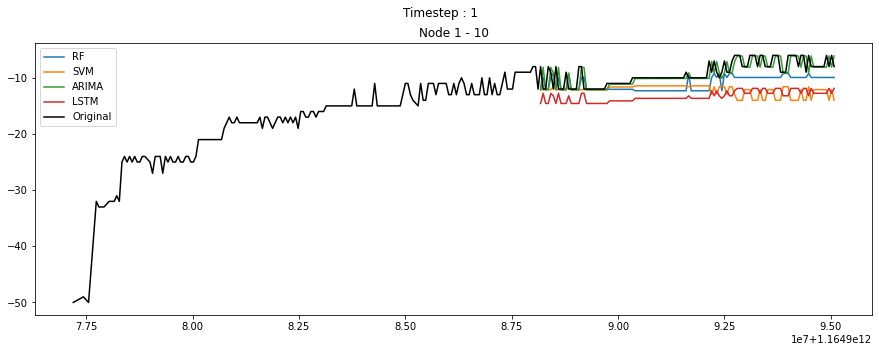

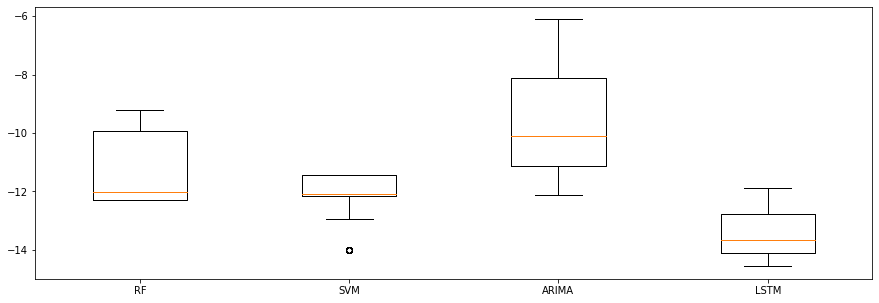

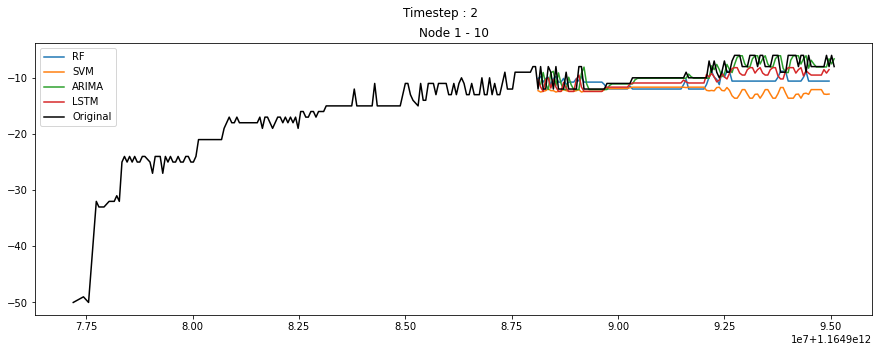

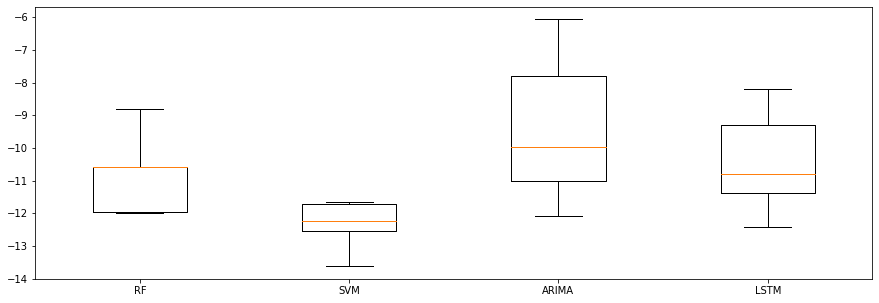

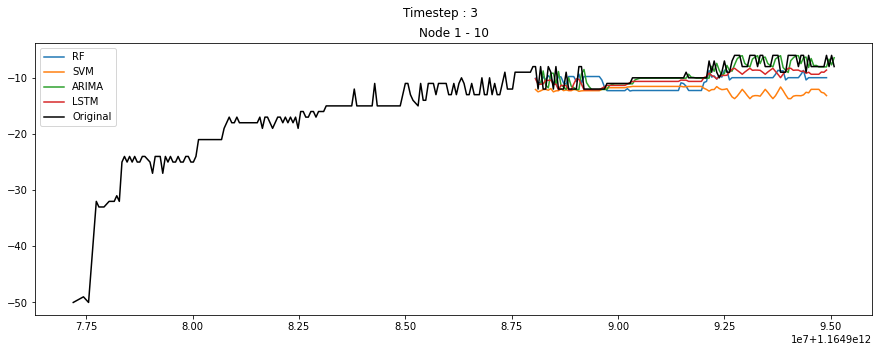

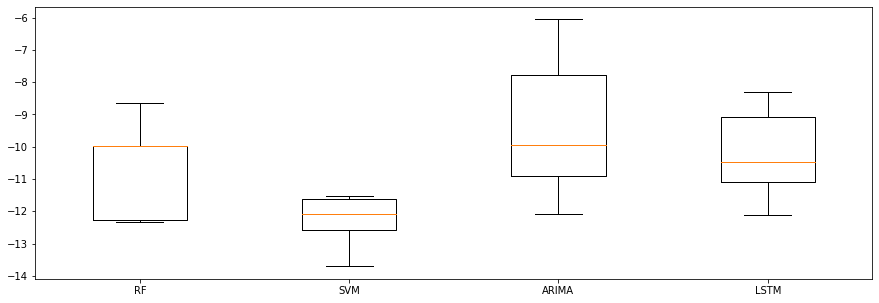

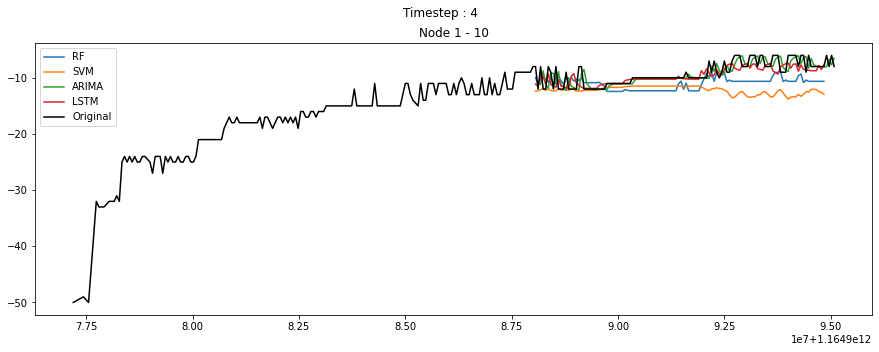

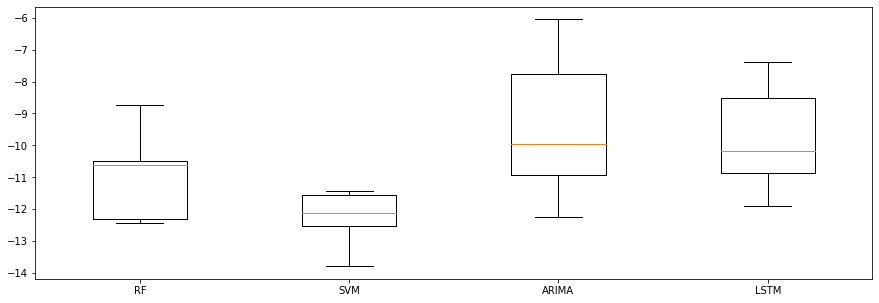

In [26]:
# --> Entrada modelos RF, SVM   dataX, dataY, pasos, diferenciada, datosOriginales, indicador

# --> Entrada ejecutarModelos  diferencia, promediada, path, nodeId, SrcNode, indicador 

#Variables de entrada
path = "/content/drive/My Drive/PROYECTO -- EXPERIMENTOS/dataAritmetica.csv"
nodeId = 1
SrcNode = 10
indicador = "LqiValue"
numNeuronas = 1
epocas = 32
    
ejecutarModelos(False, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(172, 1)
(115, 1)
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(171, 1)
(

({'Errores modelo RF : 1': (2.1386, 12.8985),
  'Errores modelo RF : 2': (1.2301, 10.4846),
  'Errores modelo RF : 3': (1.6491, 11.9395),
  'Errores modelo RF : 4': (1.4343, 11.6273)},
 {'Errores modelo SVM :1': (2.3801, 13.4966),
  'Errores modelo SVM :2': (0.3811, 6.4596),
  'Errores modelo SVM :3': (0.3366, 6.1662),
  'Errores modelo SVM :4': (0.3628, 6.2945)},
 {'Errores modelo ARIMA :1': (1.9889, 11.4395),
  'Errores modelo ARIMA :2': (1.9132, 11.4813),
  'Errores modelo ARIMA :3': (1.9171, 11.4918),
  'Errores modelo ARIMA :4': (1.9359, 11.5248)},
 {'Errores modelo LSTM : 1': (2.1822, 11.9443),
  'Errores modelo LSTM : 2': (0.276, 5.5695),
  'Errores modelo LSTM : 3': (0.3804, 6.5662),
  'Errores modelo LSTM : 4': (0.1106, 3.7111)})

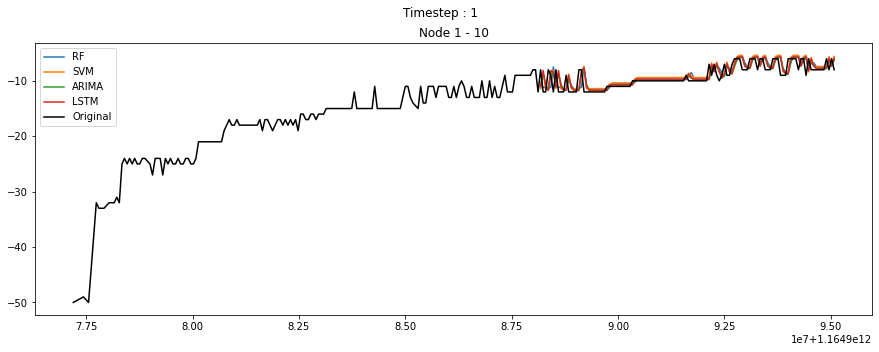

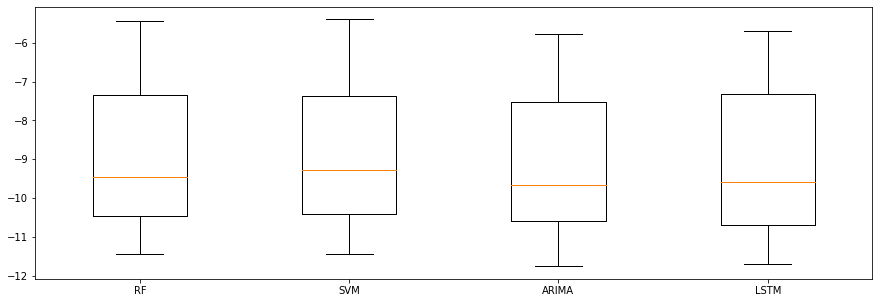

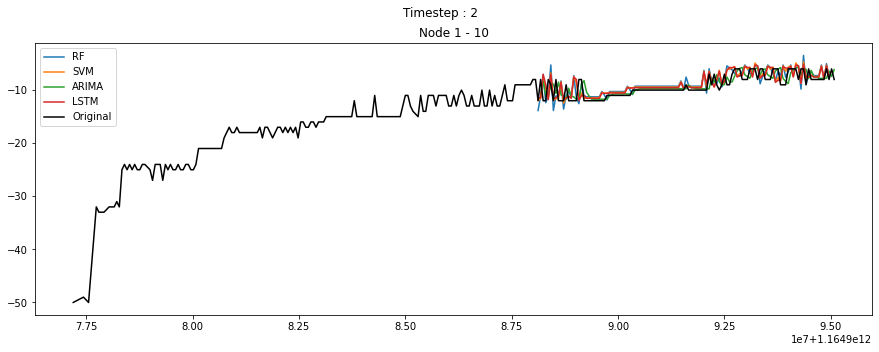

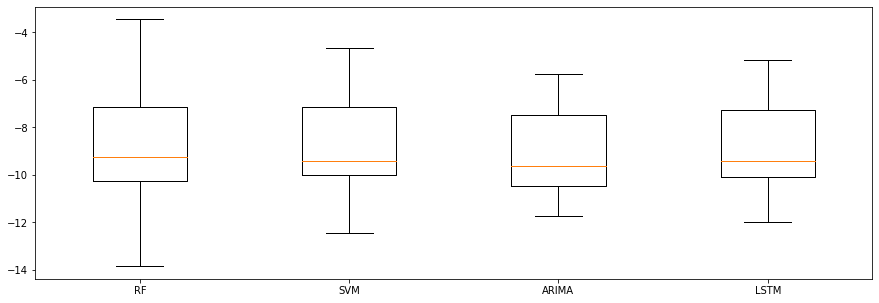

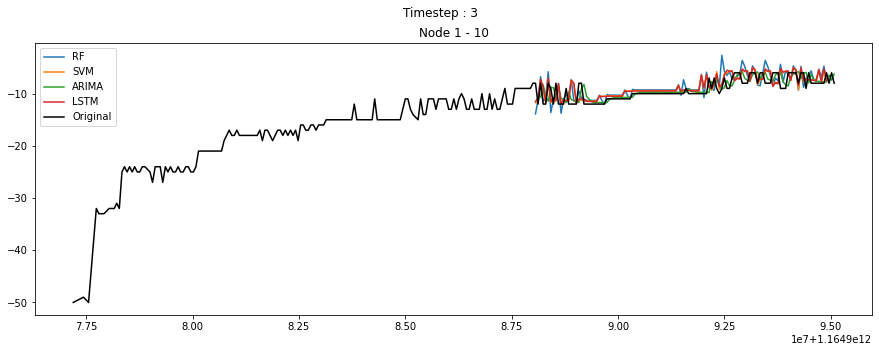

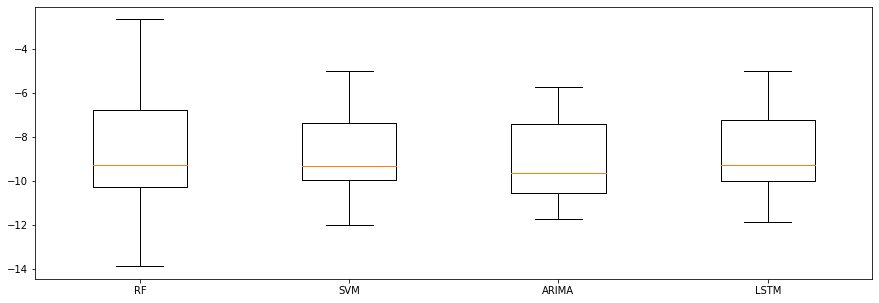

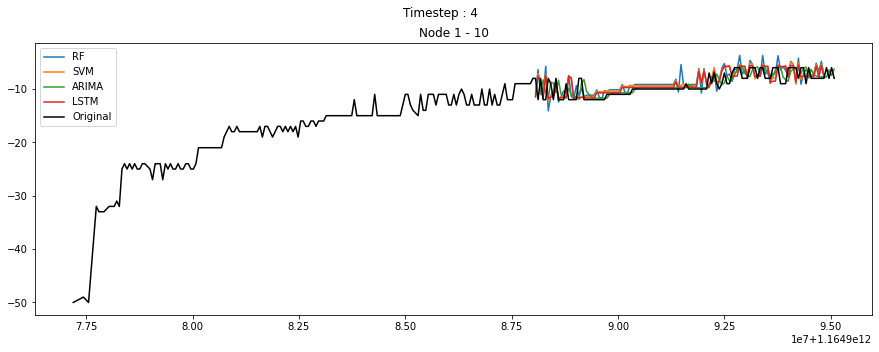

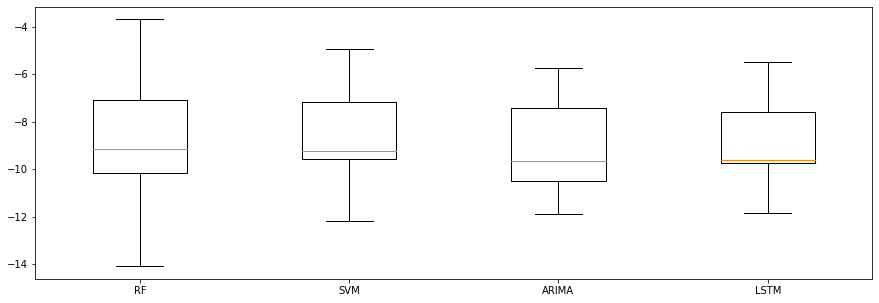

In [27]:
ejecutarModelos(True, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas )

---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(172, 1)
(115, 1)
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(171, 1)
(

({'Errores modelo RF : 1': (2.1354, 12.9216),
  'Errores modelo RF : 2': (1.2228, 10.4888),
  'Errores modelo RF : 3': (1.6358, 12.0485),
  'Errores modelo RF : 4': (1.4787, 11.6975)},
 {'Errores modelo SVM :1': (2.3801, 13.4966),
  'Errores modelo SVM :2': (0.3811, 6.4596),
  'Errores modelo SVM :3': (0.3366, 6.1662),
  'Errores modelo SVM :4': (0.3628, 6.2945)},
 {'Errores modelo ARIMA :1': (1.9889, 11.4395),
  'Errores modelo ARIMA :2': (1.9132, 11.4813),
  'Errores modelo ARIMA :3': (1.9171, 11.4918),
  'Errores modelo ARIMA :4': (1.9359, 11.5248)},
 {'Errores modelo LSTM : 1': (2.2244, 12.4804),
  'Errores modelo LSTM : 2': (0.2315, 5.489),
  'Errores modelo LSTM : 3': (0.3299, 5.4432),
  'Errores modelo LSTM : 4': (0.2238, 5.2559)})

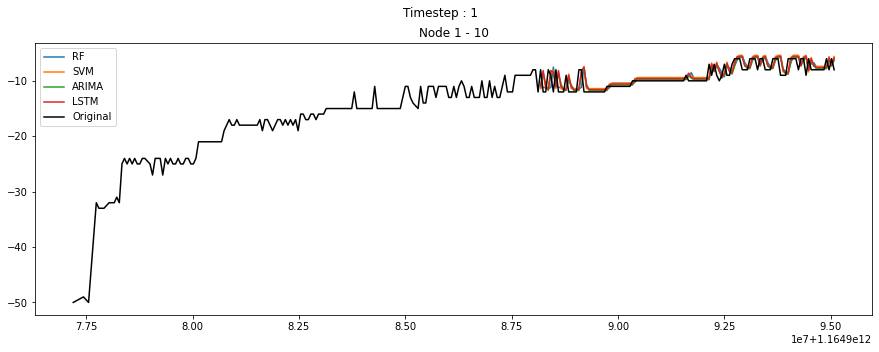

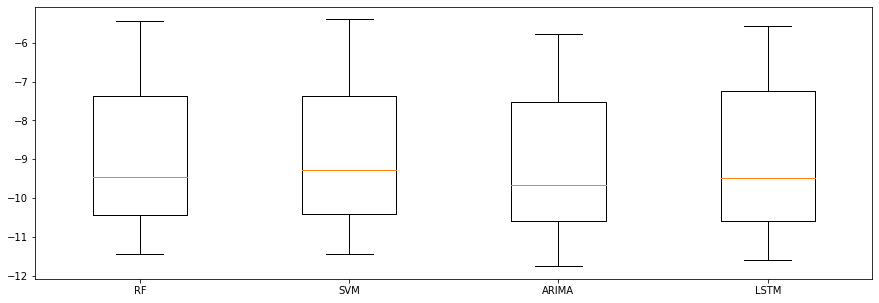

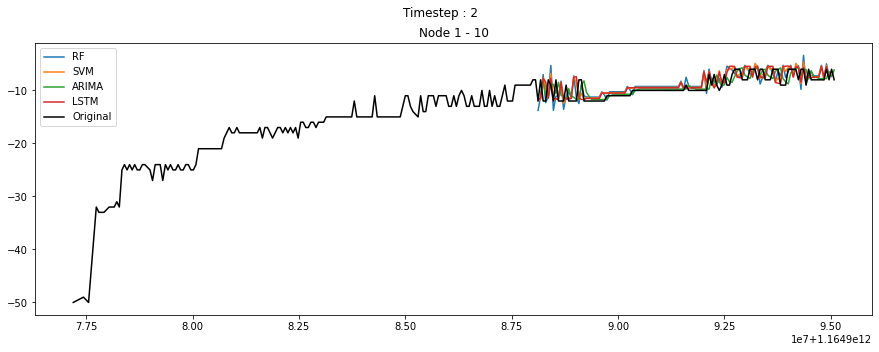

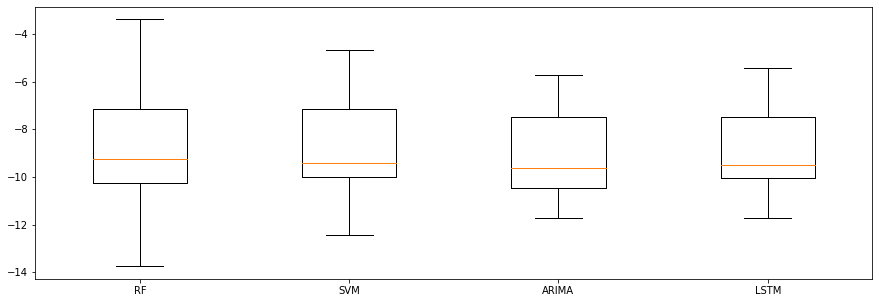

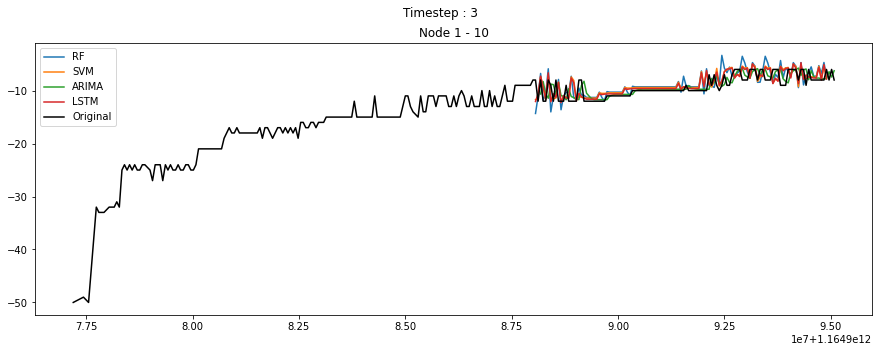

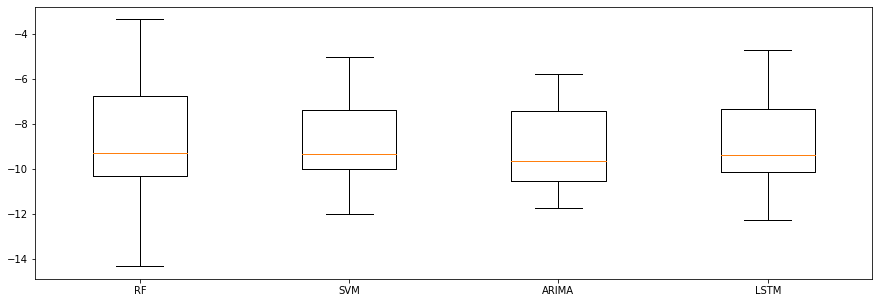

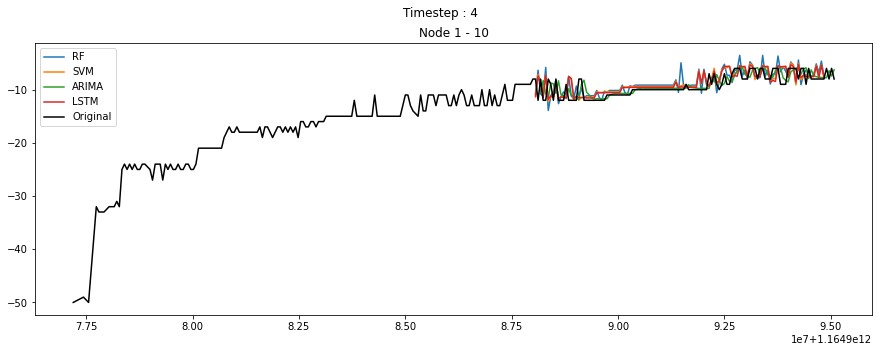

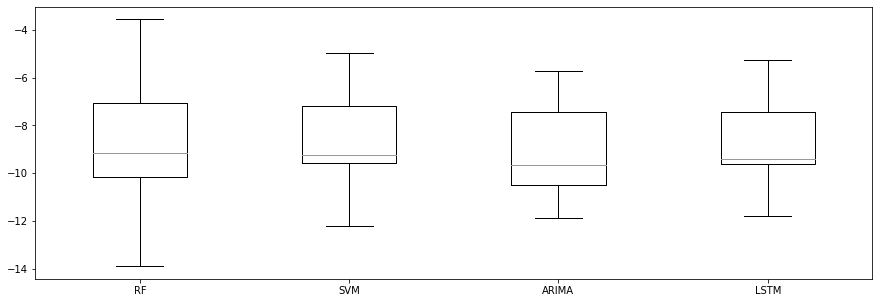

In [28]:
ejecutarModelos(True, True, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

# **Distribución arimética**

* Datos en orden par son multiplicados por un factor 0.02
* Datos en orden impar son multiplicados por un factor 0.03
* Datos en orden múltiplo de 5 son multiplicados por un factor 0.05

----------------------- SIN DIFERENCIAS ---------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(172, 1)
(115, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(171, 1)
(115, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(171, 1)
(114, 1)


({'Errores modelo RF : 1': (6.3592, 27.3315),
  'Errores modelo RF : 2': (7.401, 30.0396),
  'Errores modelo RF : 3': (6.4118, 27.8968),
  'Errores modelo RF : 4': (6.7117, 28.675)},
 {'Errores modelo SVM :1': (16.977, 44.1115),
  'Errores modelo SVM :2': (14.9223, 41.5622),
  'Errores modelo SVM :3': (14.6303, 40.827),
  'Errores modelo SVM :4': (14.6578, 40.7586)},
 {'Errores modelo ARIMA :1': (2.5719, 12.9807),
  'Errores modelo ARIMA :2': (2.1143, 12.3026),
  'Errores modelo ARIMA :3': (2.0031, 12.5068),
  'Errores modelo ARIMA :4': (1.9947, 12.53)},
 {'Errores modelo LSTM : 1': (86.9508, 109.691),
  'Errores modelo LSTM : 2': (2.9788, 17.4681),
  'Errores modelo LSTM : 3': (3.1906, 18.2773),
  'Errores modelo LSTM : 4': (2.9624, 17.5235)})

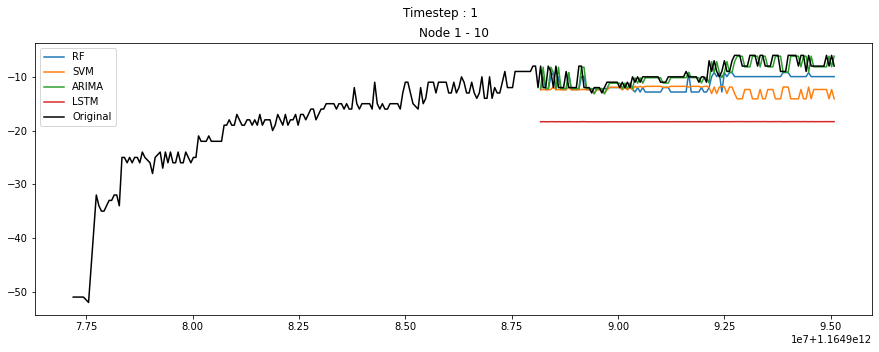

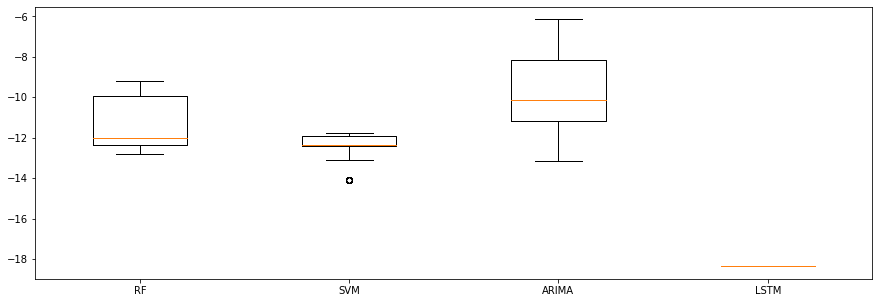

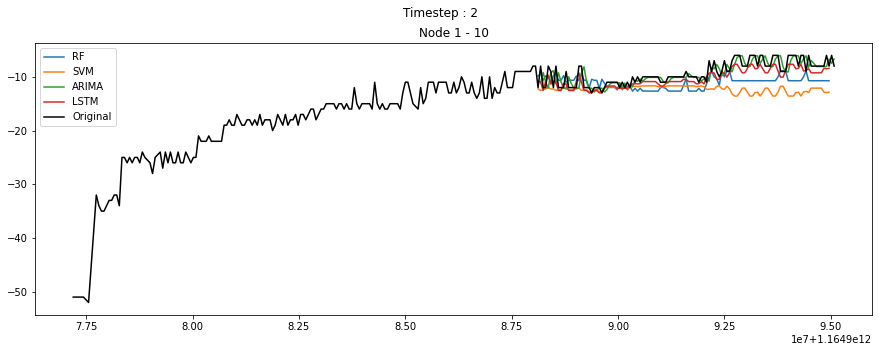

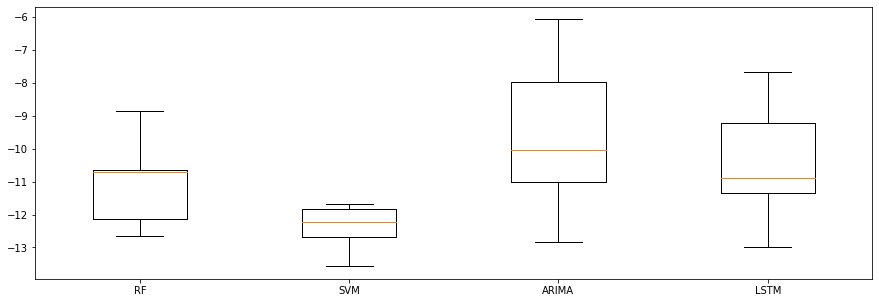

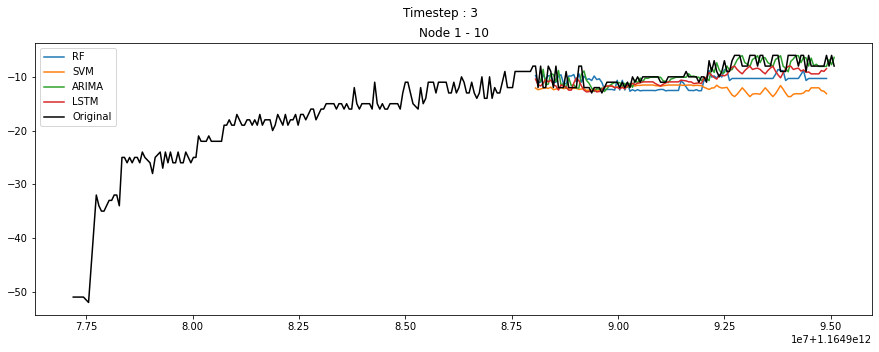

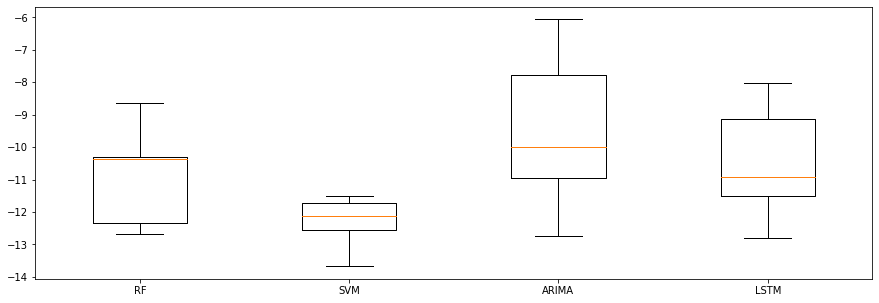

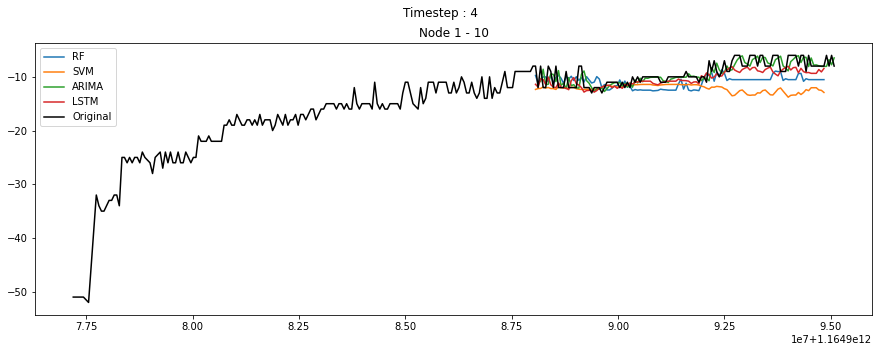

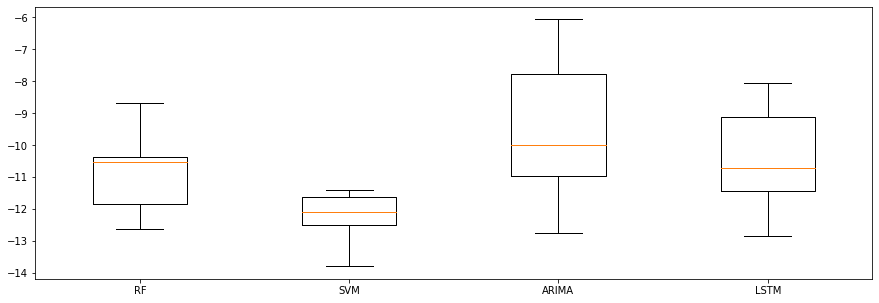

In [29]:
path = "/content/drive/My Drive/PROYECTO -- EXPERIMENTOS/dataAritmetica.csv"
nodeId = 1
SrcNode = 10
indicador = "LqiTransform"
numNeuronas = 1
epocas = 32
    
ejecutarModelos(False, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(172, 1)
(115, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(171, 1)
(115, 1)
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(171, 1)
(

({'Errores modelo RF : 1': (2.2002, 13.2007),
  'Errores modelo RF : 2': (2.2018, 10.9826),
  'Errores modelo RF : 3': (3.3513, 12.0599),
  'Errores modelo RF : 4': (2.0964, 13.2901)},
 {'Errores modelo SVM :1': (2.1851, 13.351),
  'Errores modelo SVM :2': (0.6319, 7.3786),
  'Errores modelo SVM :3': (0.5213, 7.1287),
  'Errores modelo SVM :4': (0.4336, 6.3711)},
 {'Errores modelo ARIMA :1': (2.1384, 12.3662),
  'Errores modelo ARIMA :2': (2.0519, 12.5402),
  'Errores modelo ARIMA :3': (2.0391, 12.4784),
  'Errores modelo ARIMA :4': (2.0437, 12.4818)},
 {'Errores modelo LSTM : 1': (2.3715, 12.8177),
  'Errores modelo LSTM : 2': (0.3614, 5.1196),
  'Errores modelo LSTM : 3': (0.2572, 5.7571),
  'Errores modelo LSTM : 4': (0.0629, 2.8717)})

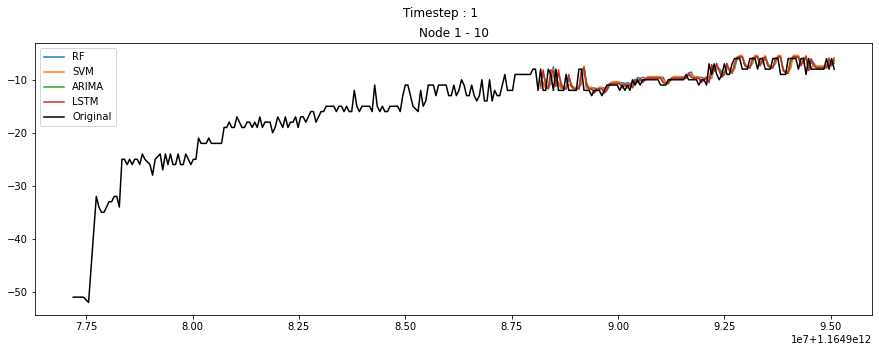

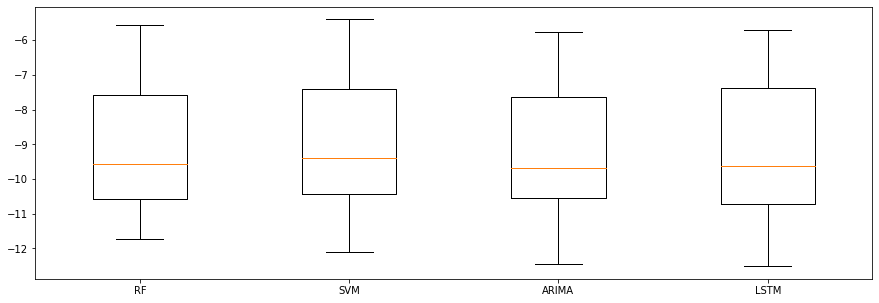

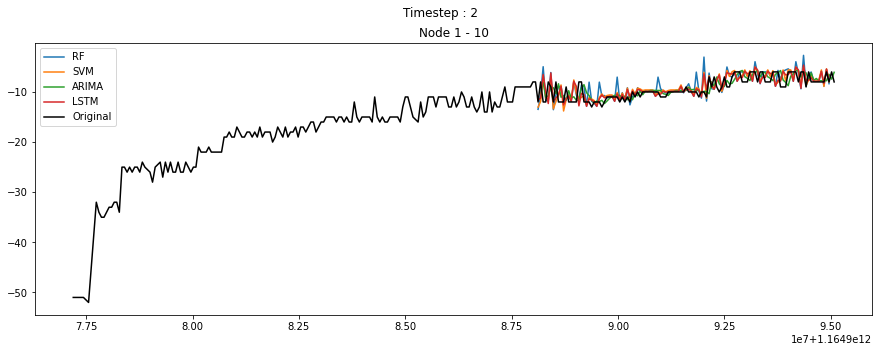

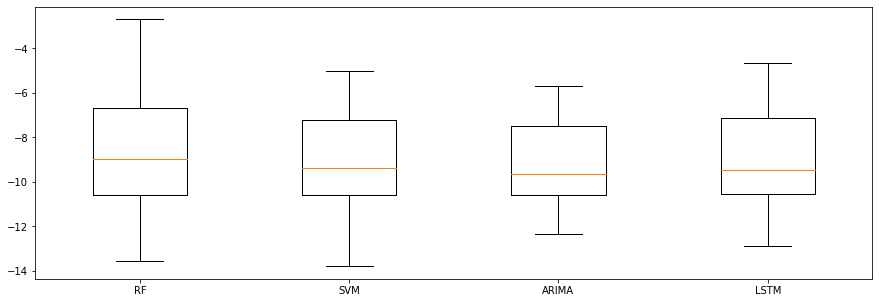

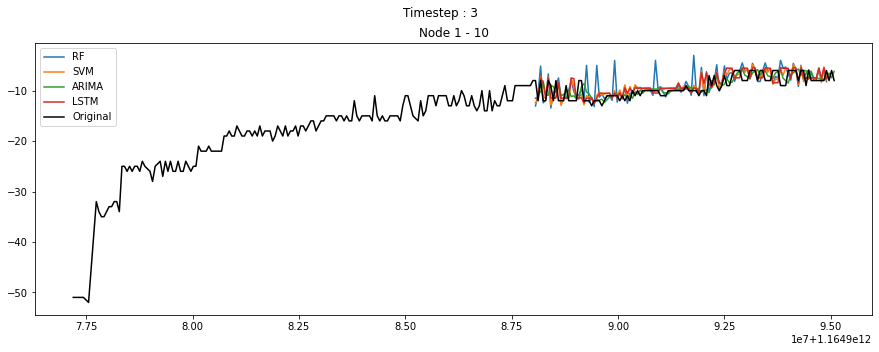

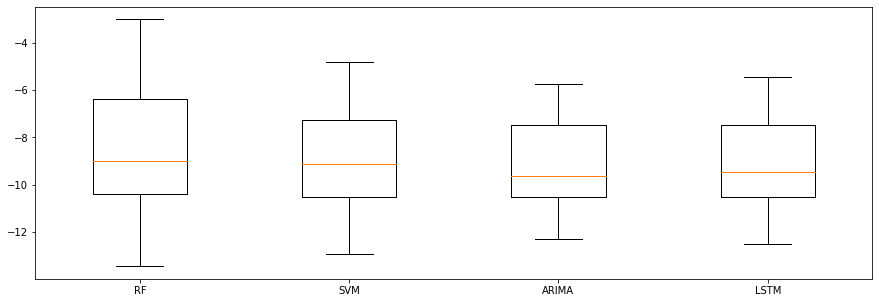

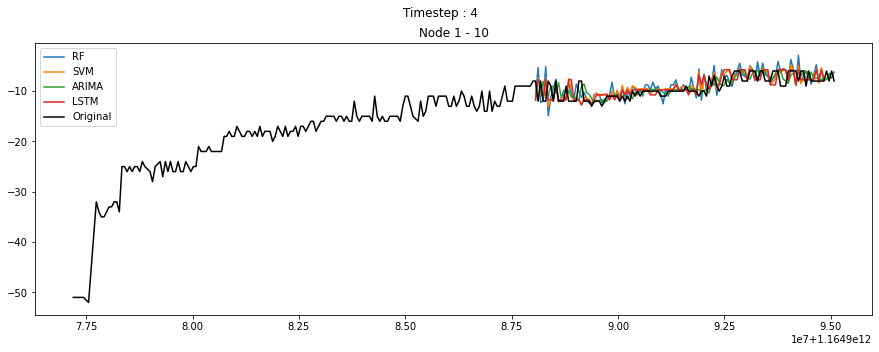

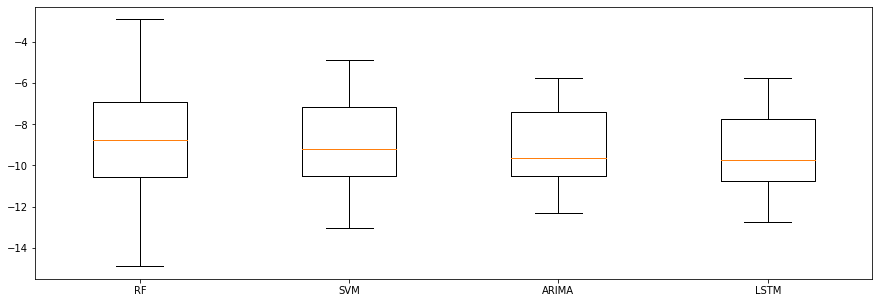

In [30]:
ejecutarModelos(True, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas )

---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(172, 1)
(115, 1)


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(171, 1)
(115, 1)
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(171, 1)
(

({'Errores modelo RF : 1': (2.2001, 13.1817),
  'Errores modelo RF : 2': (2.1461, 10.8159),
  'Errores modelo RF : 3': (3.3804, 12.0205),
  'Errores modelo RF : 4': (2.0872, 13.1979)},
 {'Errores modelo SVM :1': (2.1851, 13.351),
  'Errores modelo SVM :2': (0.6319, 7.3786),
  'Errores modelo SVM :3': (0.5213, 7.1287),
  'Errores modelo SVM :4': (0.4336, 6.3711)},
 {'Errores modelo ARIMA :1': (2.1384, 12.3662),
  'Errores modelo ARIMA :2': (2.0519, 12.5402),
  'Errores modelo ARIMA :3': (2.0391, 12.4784),
  'Errores modelo ARIMA :4': (2.0437, 12.4818)},
 {'Errores modelo LSTM : 1': (2.1698, 12.0799),
  'Errores modelo LSTM : 2': (0.1483, 4.3984),
  'Errores modelo LSTM : 3': (0.027, 1.6854),
  'Errores modelo LSTM : 4': (0.1184, 3.9185)})

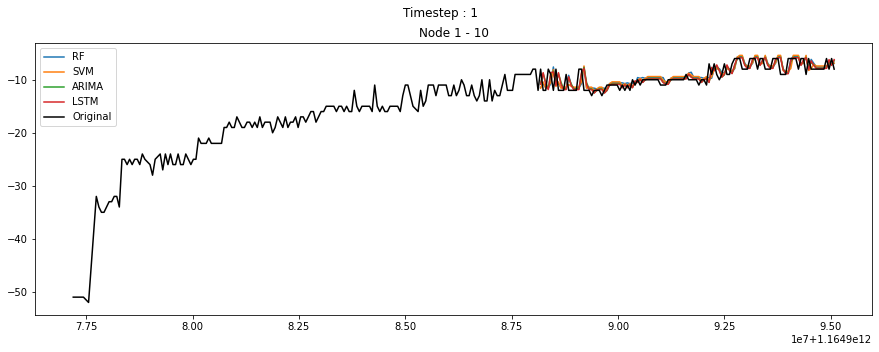

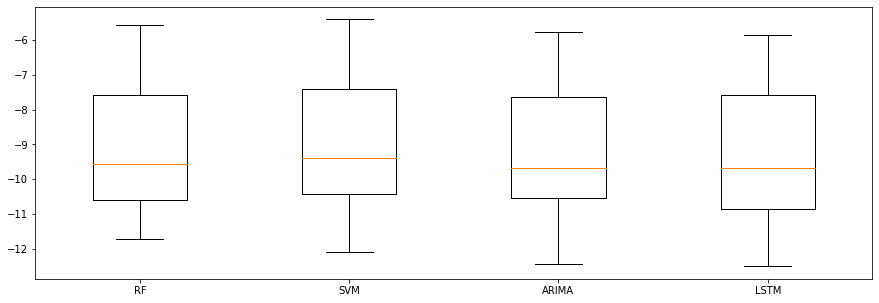

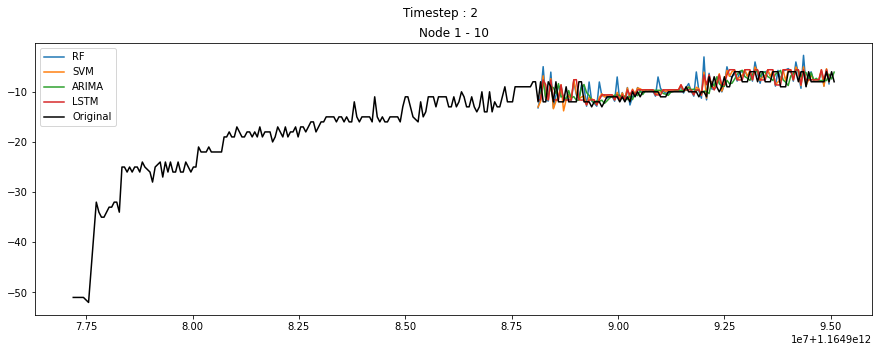

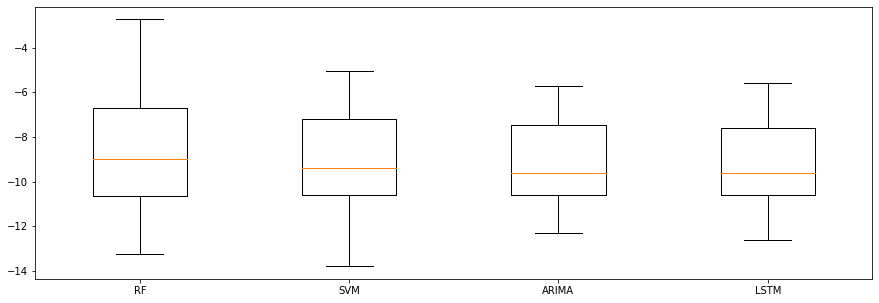

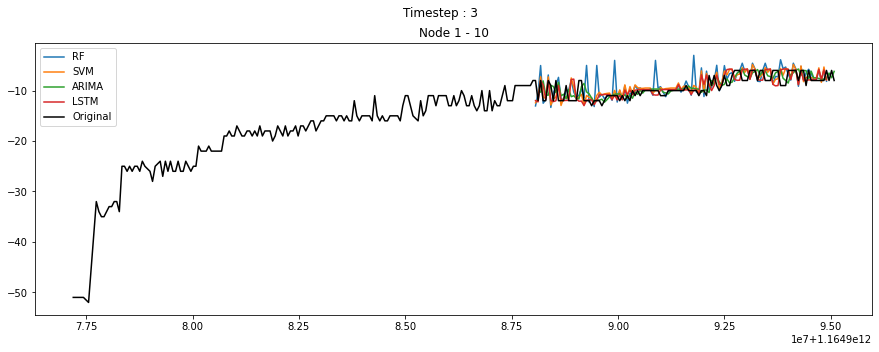

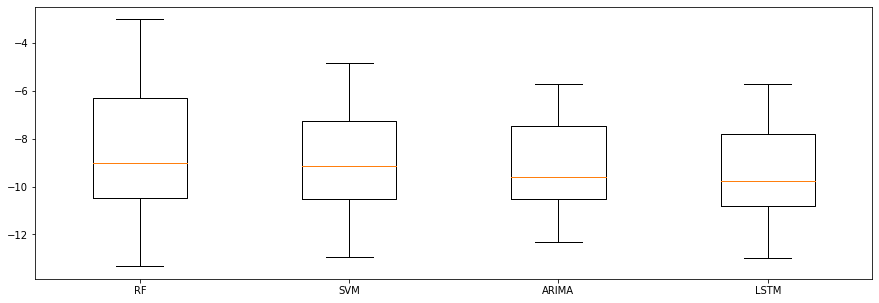

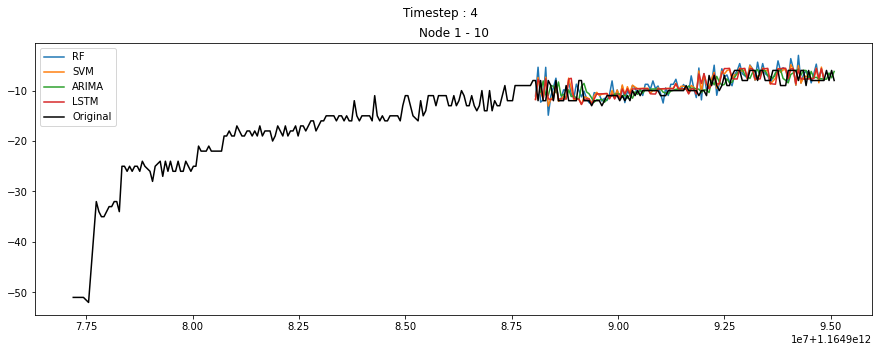

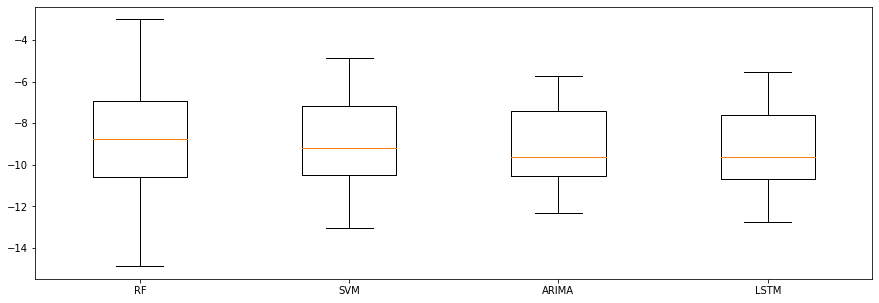

In [31]:
ejecutarModelos(True, True, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

# **Distribución Poisson**

* Para LQI
  *   media = 15
  
* Para RSSI
  * media = 210

No acumulado


----------------------- SIN DIFERENCIAS ---------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(172, 1)
(115, 1)
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(171, 1)
(

({'Errores modelo RF : 1': (896.8982, 120.0937),
  'Errores modelo RF : 2': (855.1664, 125.819),
  'Errores modelo RF : 3': (887.7541, 122.9095),
  'Errores modelo RF : 4': (841.5589, 124.861)},
 {'Errores modelo SVM :1': (387.7546, 63.5966),
  'Errores modelo SVM :2': (311.1793, 66.5608),
  'Errores modelo SVM :3': (274.1882, 70.9254),
  'Errores modelo SVM :4': (265.6512, 74.0763)},
 {'Errores modelo ARIMA :1': (382.7277, 72.0949),
  'Errores modelo ARIMA :2': (329.395, 64.9878),
  'Errores modelo ARIMA :3': (297.8583, 63.9029),
  'Errores modelo ARIMA :4': (303.8747, 63.8516)},
 {'Errores modelo LSTM : 1': (507.5309, 139.1966),
  'Errores modelo LSTM : 2': (312.1762, 58.9933),
  'Errores modelo LSTM : 3': (299.1139, 63.5317),
  'Errores modelo LSTM : 4': (273.1664, 62.5306)})

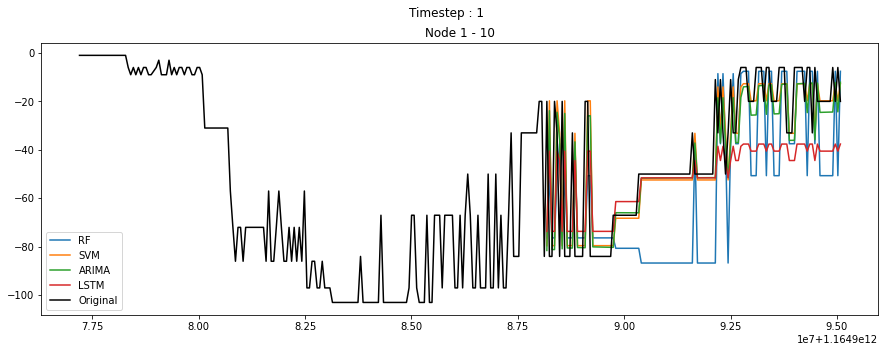

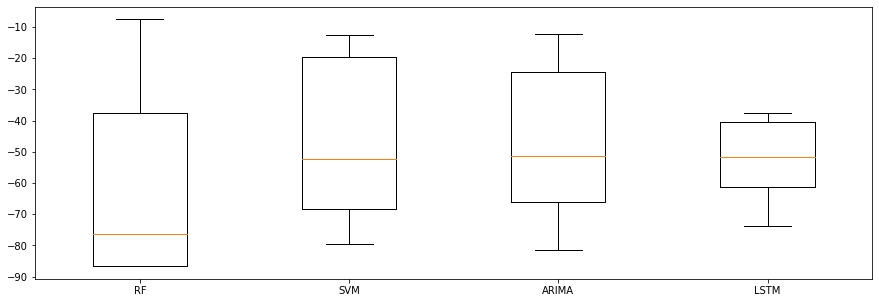

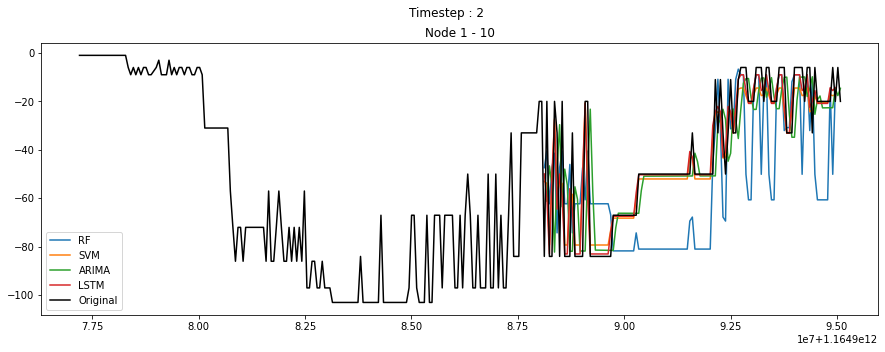

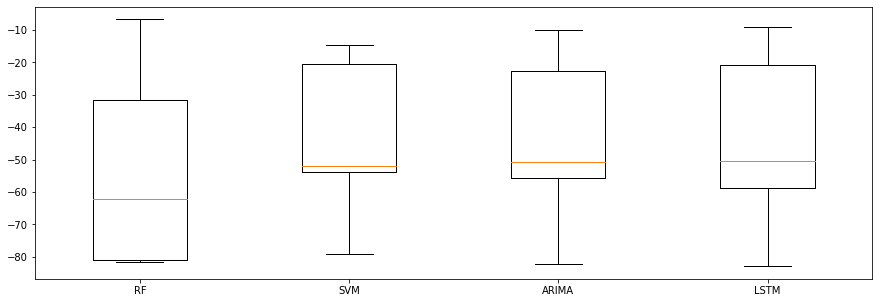

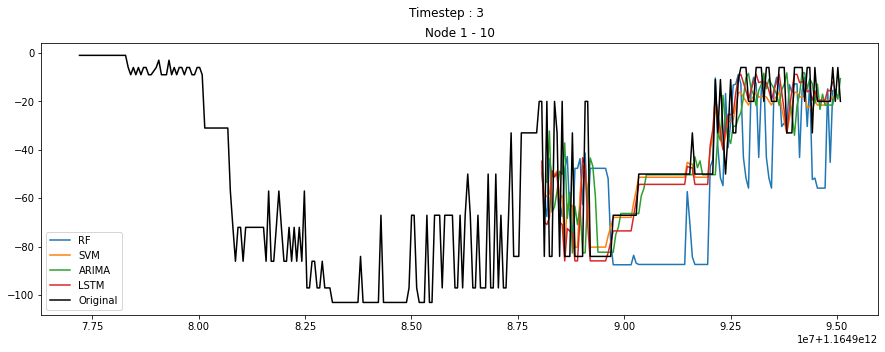

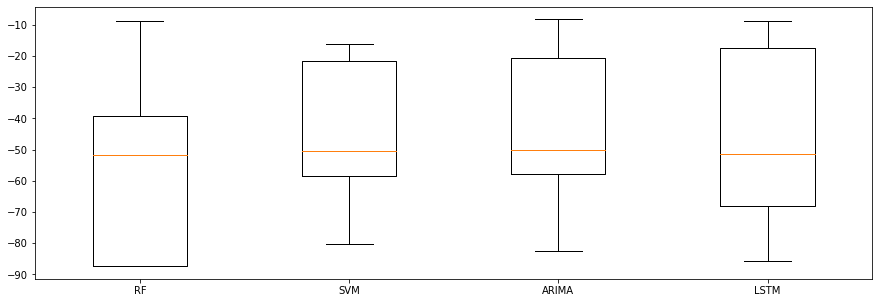

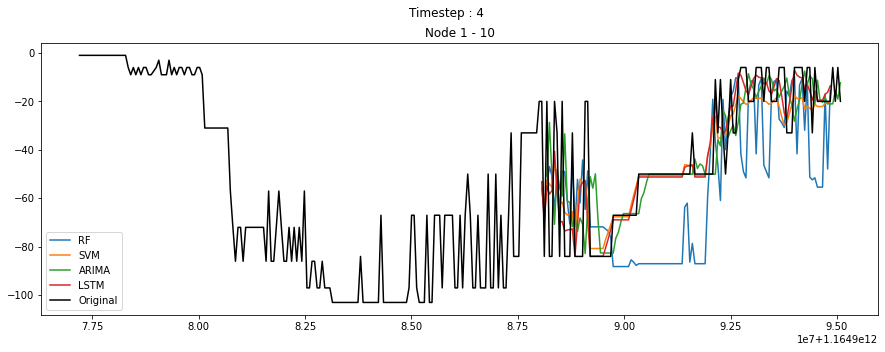

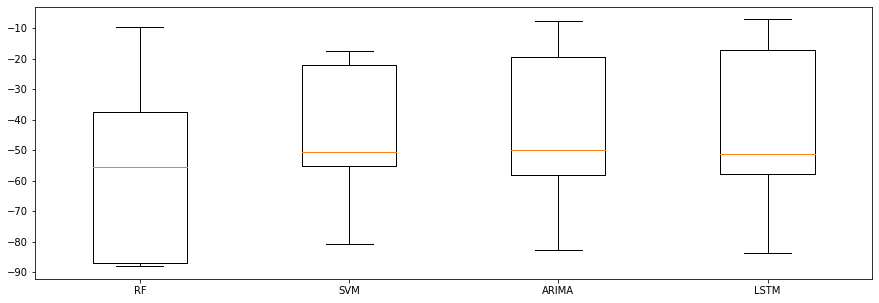

In [32]:
path = "/content/drive/My Drive/PROYECTO -- EXPERIMENTOS/dataPoisson.csv"
nodeId = 1
SrcNode = 10
indicador = "LqiTransform"
numNeuronas = 1
epocas = 32
    
ejecutarModelos(False, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(172, 1)
(115, 1)
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(171, 1)
(

({'Errores modelo RF : 1': (406.171, 66.1979),
  'Errores modelo RF : 2': (134.0442, 39.8525),
  'Errores modelo RF : 3': (185.9484, 41.7386),
  'Errores modelo RF : 4': (189.2608, 42.7877)},
 {'Errores modelo SVM :1': (402.5008, 56.7461),
  'Errores modelo SVM :2': (0.9956, 4.3408),
  'Errores modelo SVM :3': (0.7899, 4.1314),
  'Errores modelo SVM :4': (0.6762, 3.7237)},
 {'Errores modelo ARIMA :1': (341.9172, 56.0697),
  'Errores modelo ARIMA :2': (303.5385, 60.0102),
  'Errores modelo ARIMA :3': (308.284, 61.9089),
  'Errores modelo ARIMA :4': (307.3007, 62.0133)},
 {'Errores modelo LSTM : 1': (423.5931, 61.1917),
  'Errores modelo LSTM : 2': (2.7, 4.7729),
  'Errores modelo LSTM : 3': (4.1163, 6.6232),
  'Errores modelo LSTM : 4': (1.1369, 2.8613)})

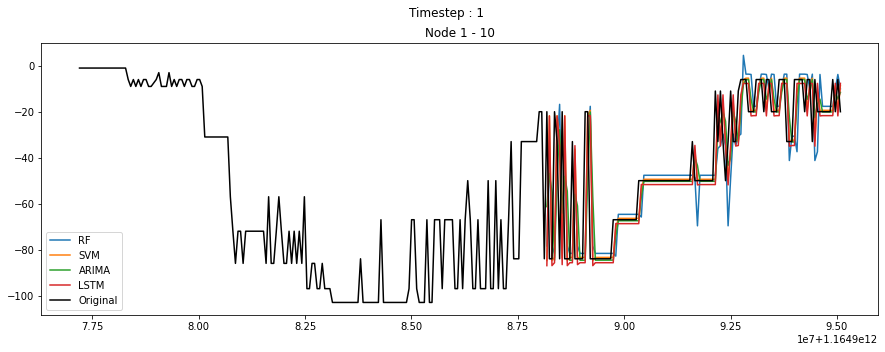

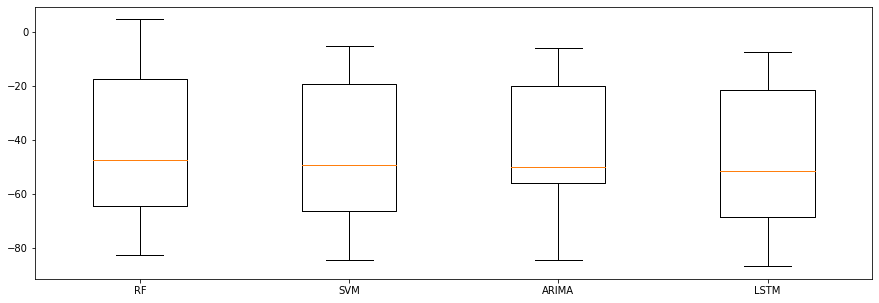

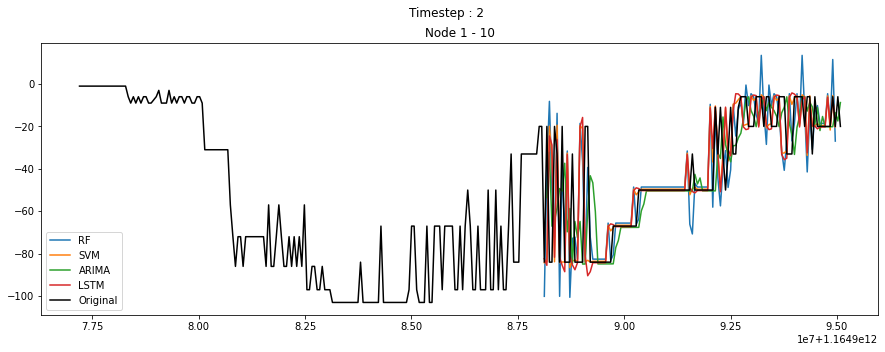

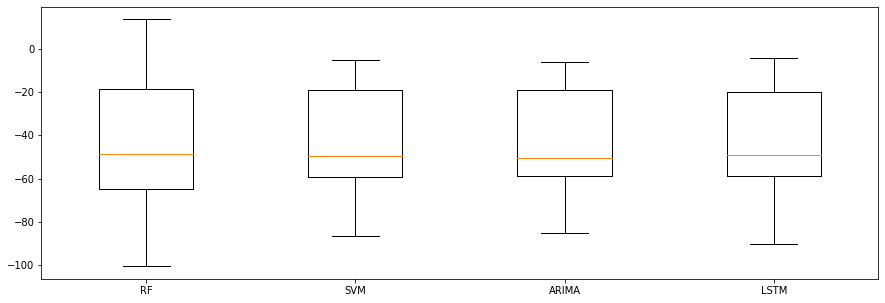

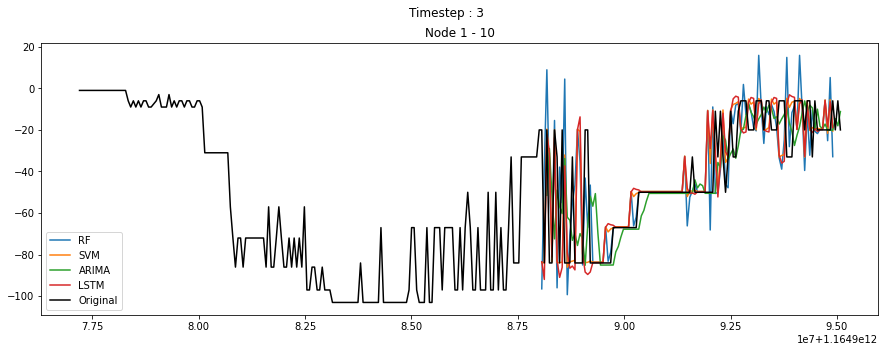

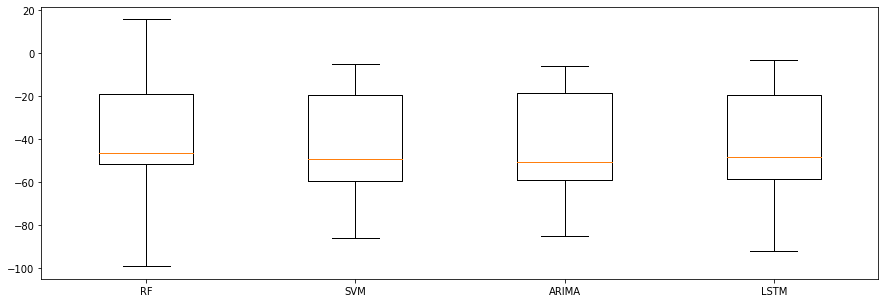

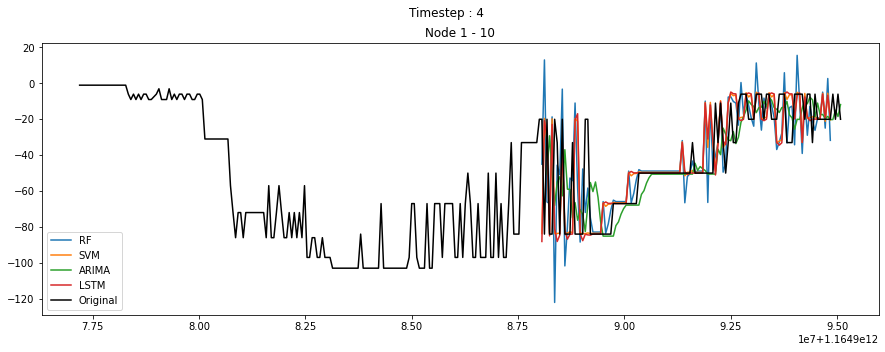

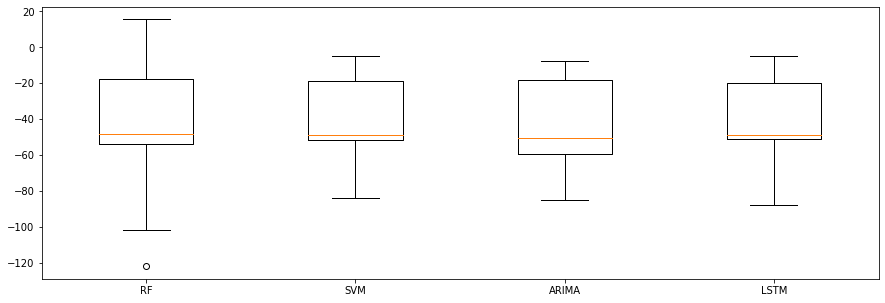

In [33]:
ejecutarModelos(True, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas )

---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(172, 1)
(115, 1)
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(171, 1)
(

({'Errores modelo RF : 1': (405.8884, 66.5262),
  'Errores modelo RF : 2': (132.7627, 41.566),
  'Errores modelo RF : 3': (183.913, 40.7616),
  'Errores modelo RF : 4': (197.768, 44.2379)},
 {'Errores modelo SVM :1': (402.5008, 56.7461),
  'Errores modelo SVM :2': (0.9956, 4.3408),
  'Errores modelo SVM :3': (0.7899, 4.1314),
  'Errores modelo SVM :4': (0.6762, 3.7237)},
 {'Errores modelo ARIMA :1': (341.9172, 56.0697),
  'Errores modelo ARIMA :2': (303.5385, 60.0102),
  'Errores modelo ARIMA :3': (308.284, 61.9089),
  'Errores modelo ARIMA :4': (307.3007, 62.0133)},
 {'Errores modelo LSTM : 1': (480.2767, 60.7959),
  'Errores modelo LSTM : 2': (0.8377, 2.1649),
  'Errores modelo LSTM : 3': (34.7694, 19.3984),
  'Errores modelo LSTM : 4': (8.2105, 9.0928)})

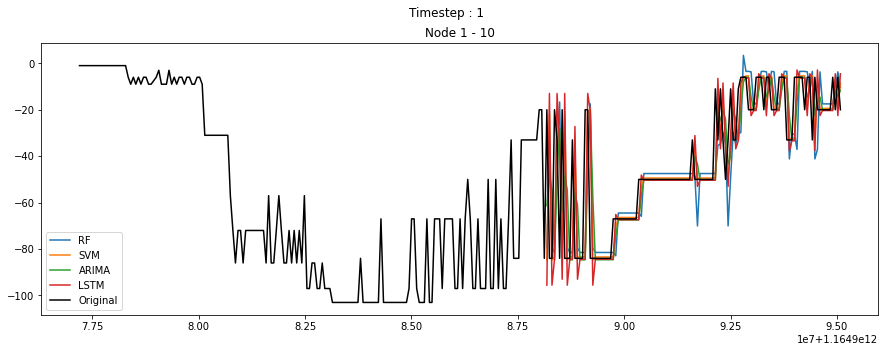

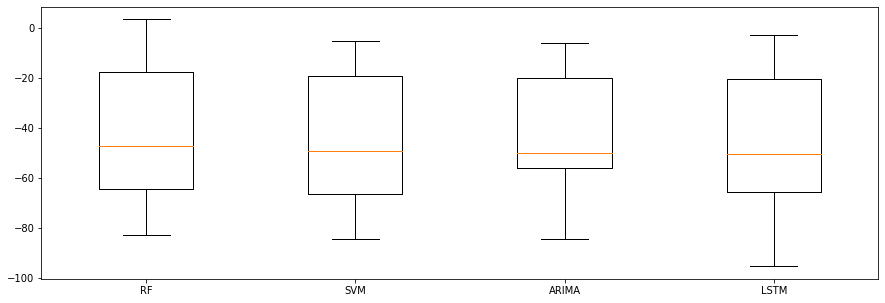

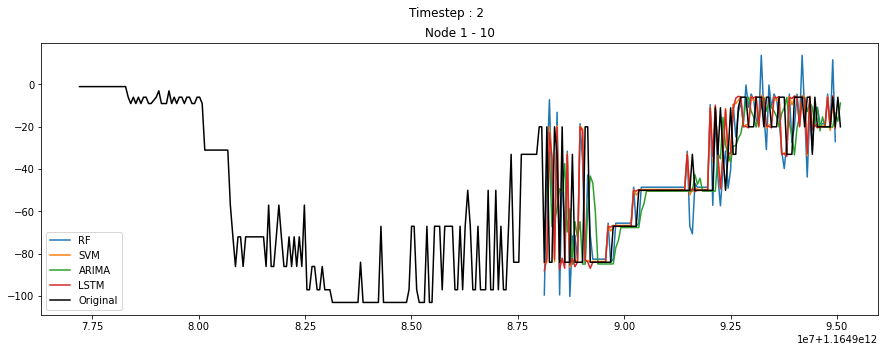

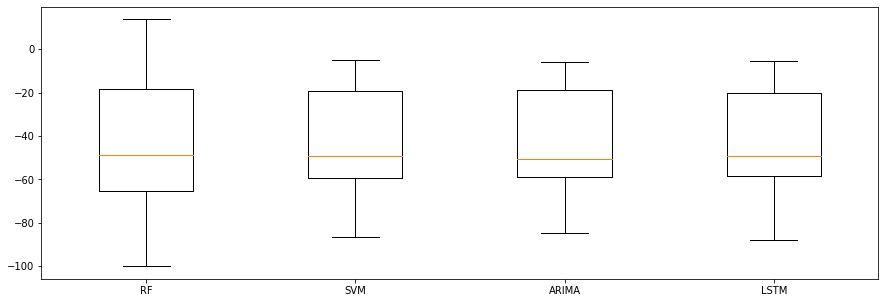

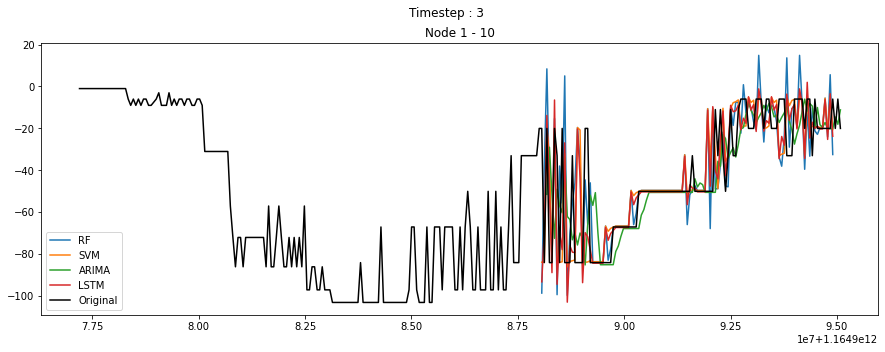

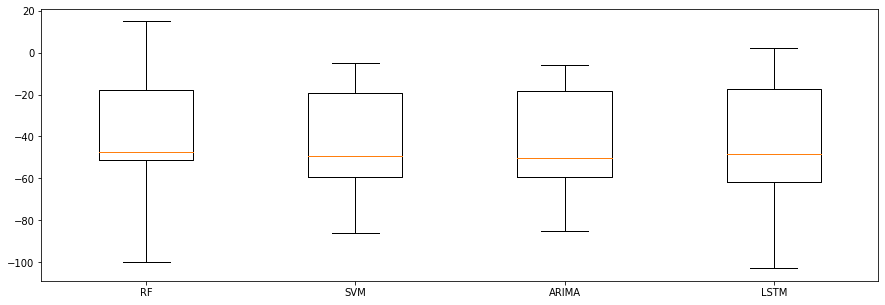

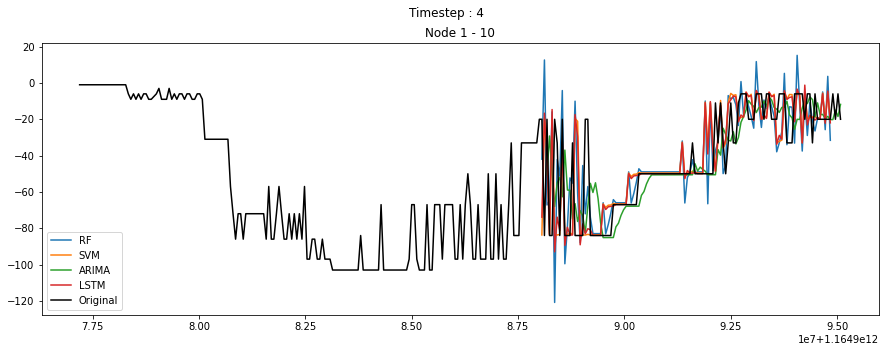

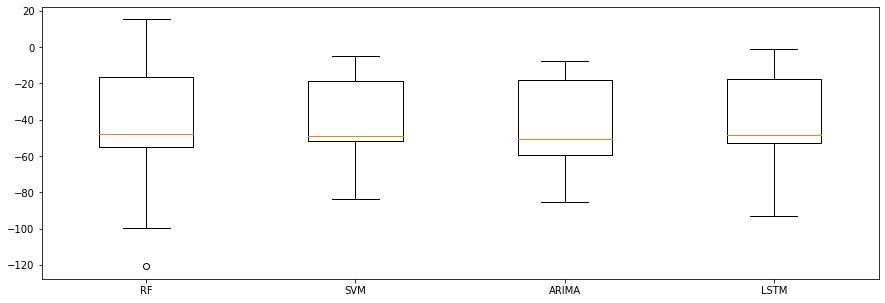

In [34]:
ejecutarModelos(True, True, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

# **Distribución Gamma**
* Para LQI
  alfa = 10
  beta = 3

* Para RSSI
  alfa = 10
  beta = 15

No acumulado

----------------------- SIN DIFERENCIAS ---------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:126: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(172, 1)
(115, 1)
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(171, 1)
(

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(171, 1)
(114, 1)


({'Errores modelo RF : 1': (0.2647, 47.895),
  'Errores modelo RF : 2': (0.1733, 34.887),
  'Errores modelo RF : 3': (0.1966, 35.6168),
  'Errores modelo RF : 4': (0.1546, 30.902)},
 {'Errores modelo SVM :1': (2.0962, 135.2695),
  'Errores modelo SVM :2': (1.93, 129.776),
  'Errores modelo SVM :3': (1.3449, 108.122),
  'Errores modelo SVM :4': (1.1003, 97.9334)},
 {'Errores modelo ARIMA :1': (0.1252, 21.0165),
  'Errores modelo ARIMA :2': (0.1012, 17.8287),
  'Errores modelo ARIMA :3': (0.0955, 16.8519),
  'Errores modelo ARIMA :4': (0.0972, 17.2815)},
 {'Errores modelo LSTM : 1': (14.3089, 350.1842),
  'Errores modelo LSTM : 2': (4.758, 202.5615),
  'Errores modelo LSTM : 3': (125.8015, 1035.1911),
  'Errores modelo LSTM : 4': (0.1686, 35.9364)})

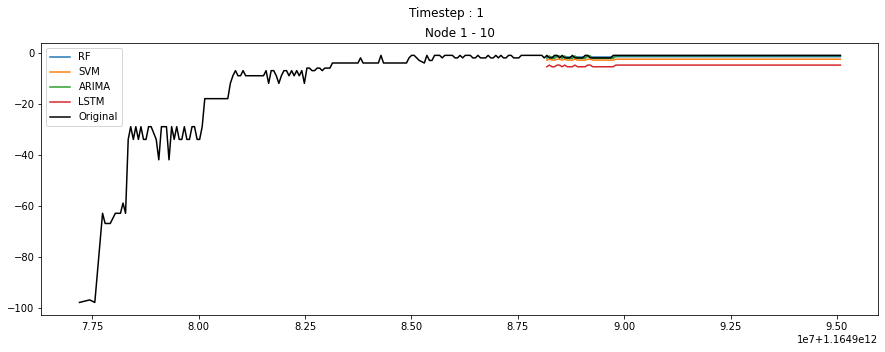

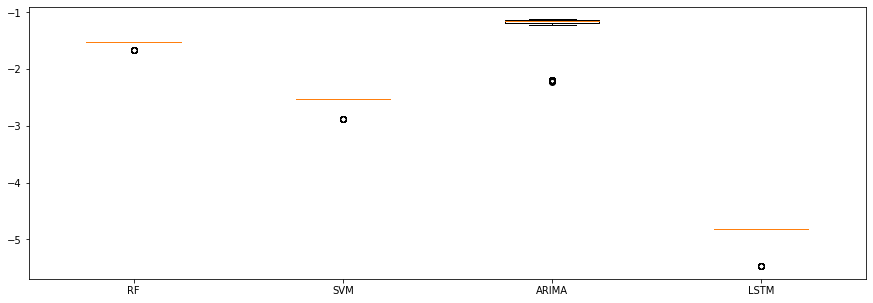

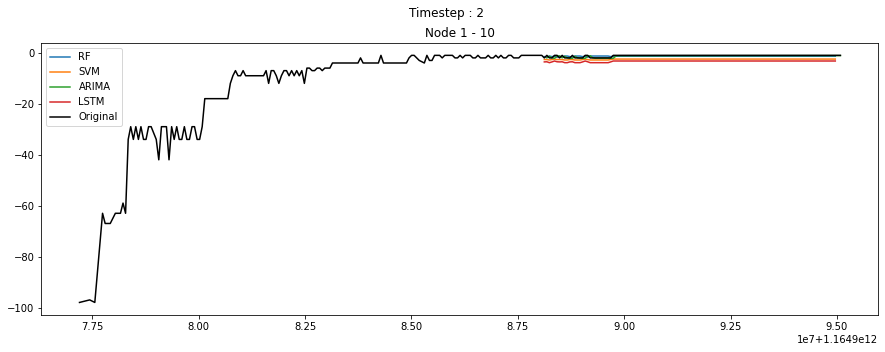

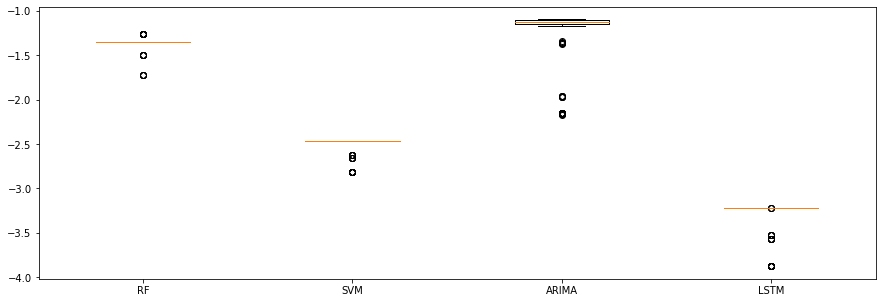

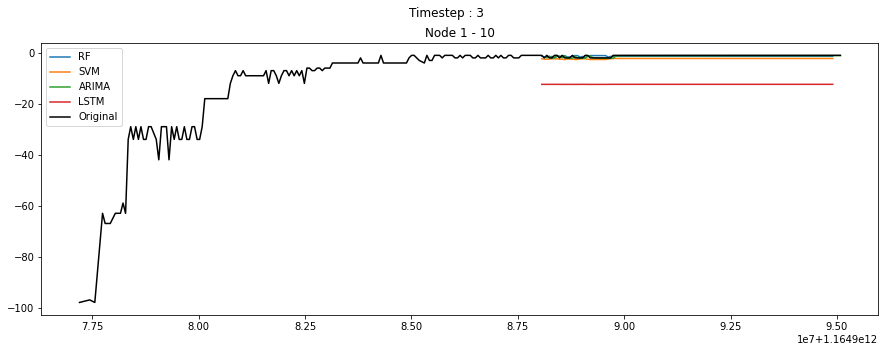

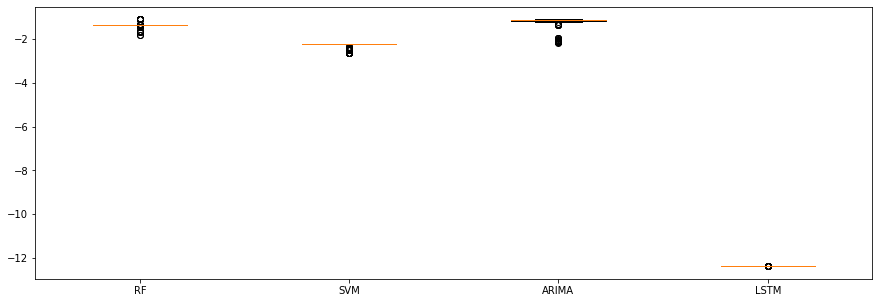

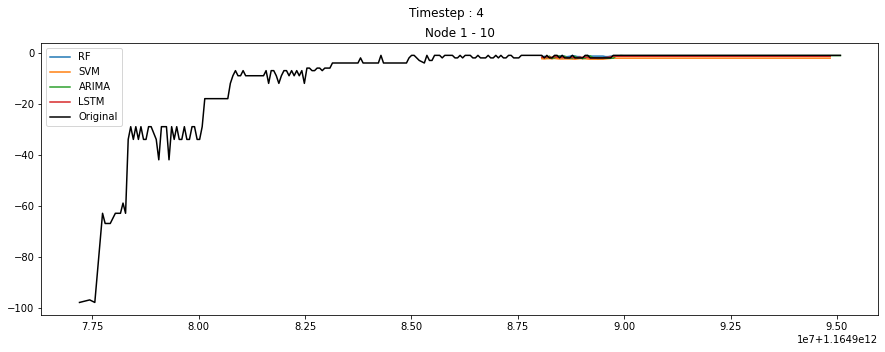

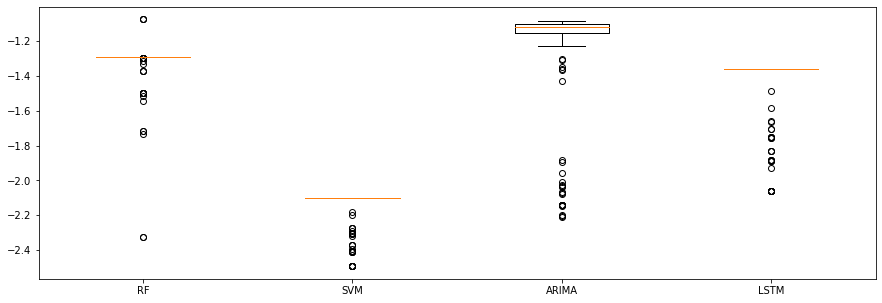

In [35]:
path = "/content/drive/My Drive/PROYECTO -- EXPERIMENTOS/dataGamma.csv"
nodeId = 1
SrcNode = 10
indicador = "LqiTransform"
numNeuronas = 1
epocas = 32
    
ejecutarModelos(False, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas)

-----------------------  SERIE DE DIFERENCIAS -----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(172, 1)
(115, 1)
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(171, 1)
(

({'Errores modelo RF : 1': (0.6712, 57.3467),
  'Errores modelo RF : 2': (1.323, 76.0348),
  'Errores modelo RF : 3': (0.5426, 66.5598),
  'Errores modelo RF : 4': (0.6652, 74.3653)},
 {'Errores modelo SVM :1': (0.3157, 46.4864),
  'Errores modelo SVM :2': (0.2407, 44.0161),
  'Errores modelo SVM :3': (0.2303, 42.1683),
  'Errores modelo SVM :4': (0.2214, 42.3989)},
 {'Errores modelo ARIMA :1': (0.3515, 47.036),
  'Errores modelo ARIMA :2': (0.4073, 50.8569),
  'Errores modelo ARIMA :3': (0.3919, 49.7326),
  'Errores modelo ARIMA :4': (0.3708, 48.2911)},
 {'Errores modelo LSTM : 1': (1.0938, 89.7148),
  'Errores modelo LSTM : 2': (0.6604, 74.8288),
  'Errores modelo LSTM : 3': (2.7112, 150.9511),
  'Errores modelo LSTM : 4': (0.5617, 68.5197)})

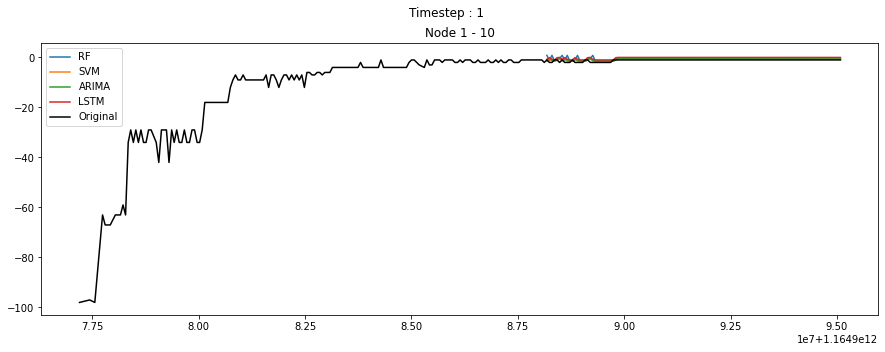

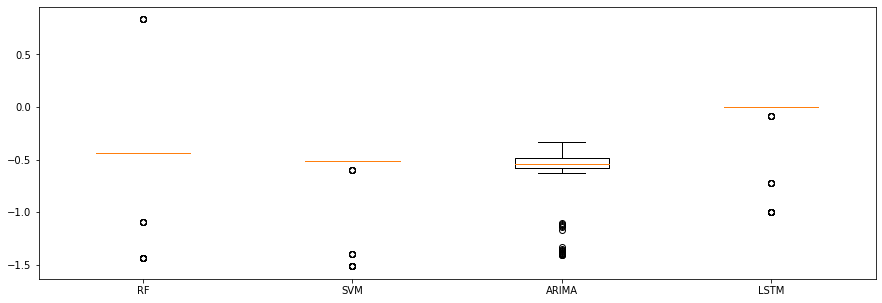

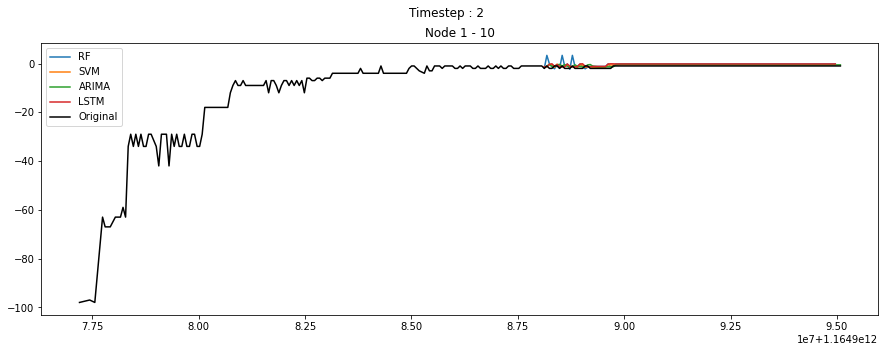

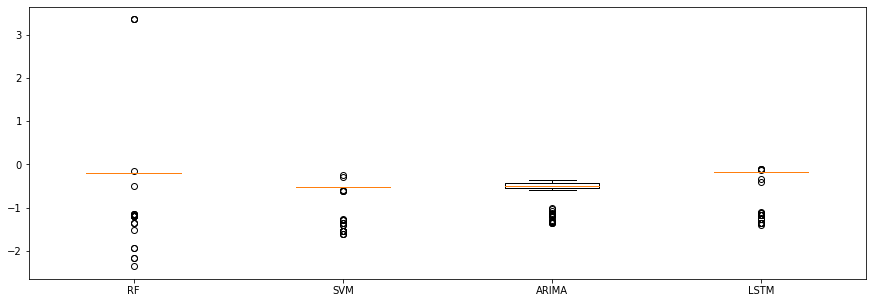

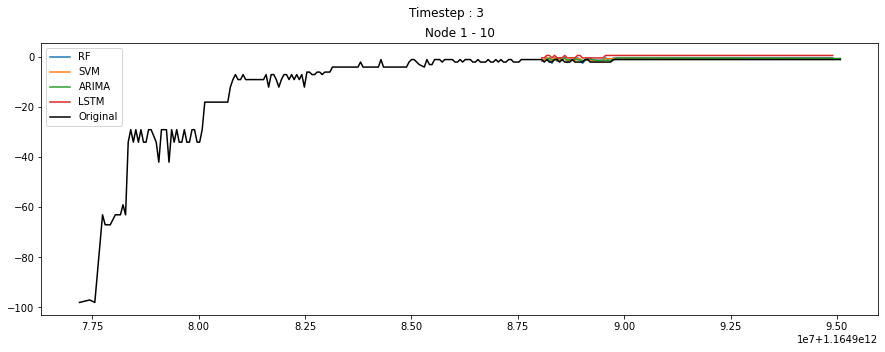

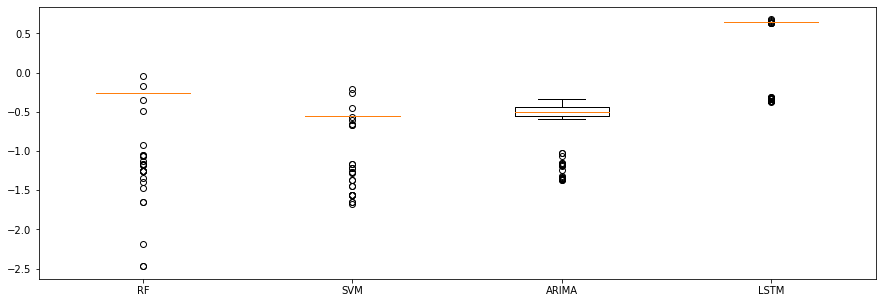

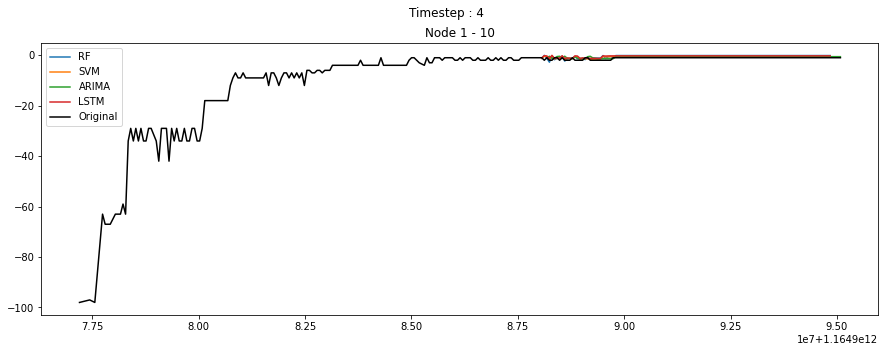

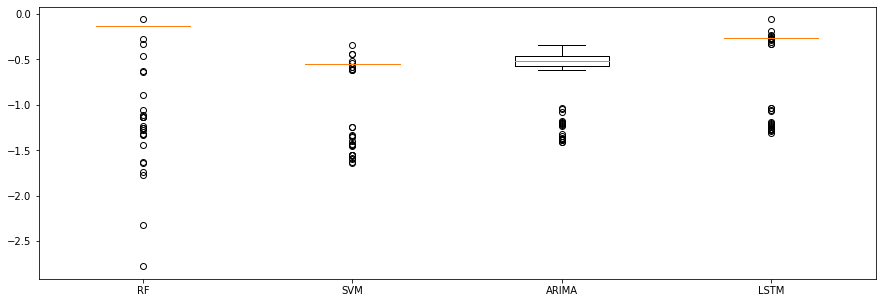

In [36]:
ejecutarModelos(True, False, path, nodeId, SrcNode, indicador, numNeuronas, epocas )

---------------------SERIE DE DIFERENCIAS Y PROMEDIADAS-----------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(172, 1)
(115, 1)
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
None
(171, 1)
(

({'Errores modelo RF : 1': (0.6738, 56.2167),
  'Errores modelo RF : 2': (1.6831, 78.4196),
  'Errores modelo RF : 3': (0.5553, 67.3935),
  'Errores modelo RF : 4': (0.666, 74.454)},
 {'Errores modelo SVM :1': (0.3157, 46.4864),
  'Errores modelo SVM :2': (0.2407, 44.0161),
  'Errores modelo SVM :3': (0.2303, 42.1683),
  'Errores modelo SVM :4': (0.2214, 42.3989)},
 {'Errores modelo ARIMA :1': (0.3515, 47.036),
  'Errores modelo ARIMA :2': (0.4073, 50.8569),
  'Errores modelo ARIMA :3': (0.3919, 49.7326),
  'Errores modelo ARIMA :4': (0.3708, 48.2911)},
 {'Errores modelo LSTM : 1': (0.7627, 74.5471),
  'Errores modelo LSTM : 2': (1.7941, 123.0204),
  'Errores modelo LSTM : 3': (0.2562, 46.5943),
  'Errores modelo LSTM : 4': (0.3514, 54.2343)})

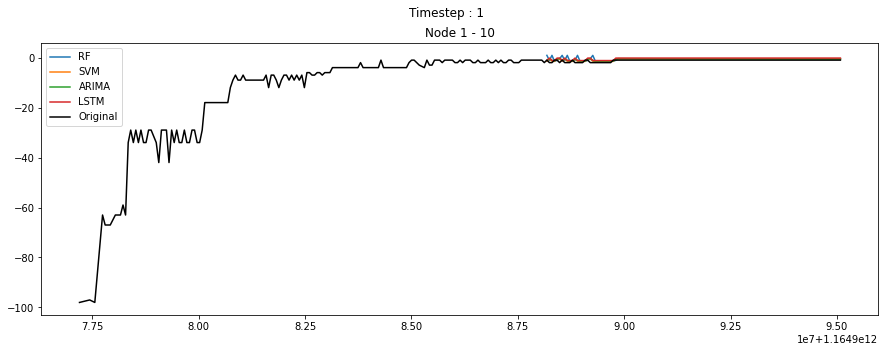

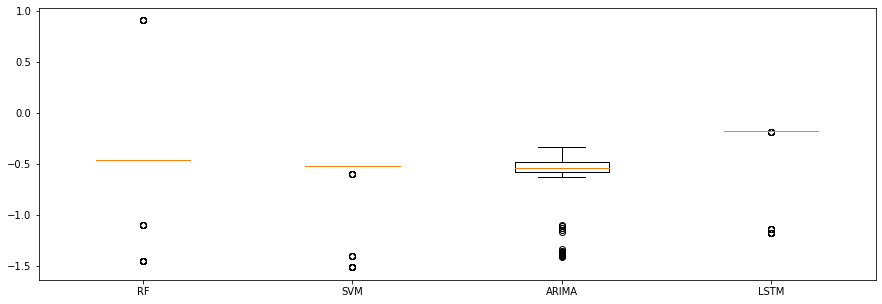

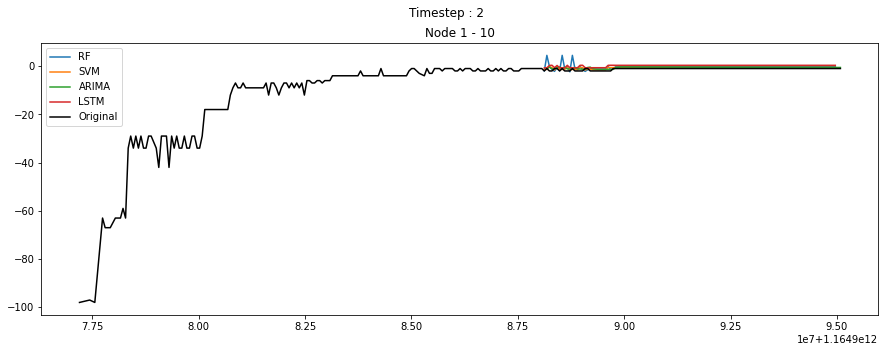

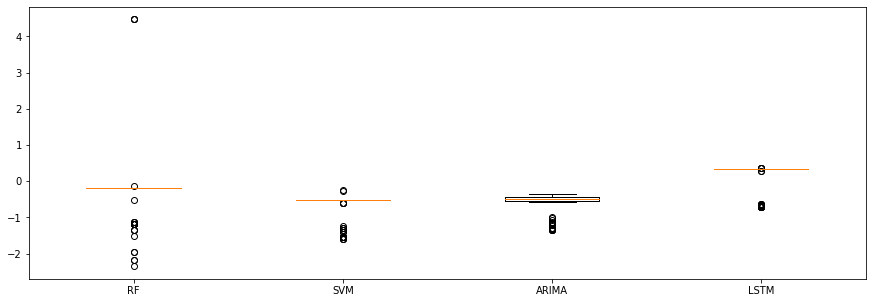

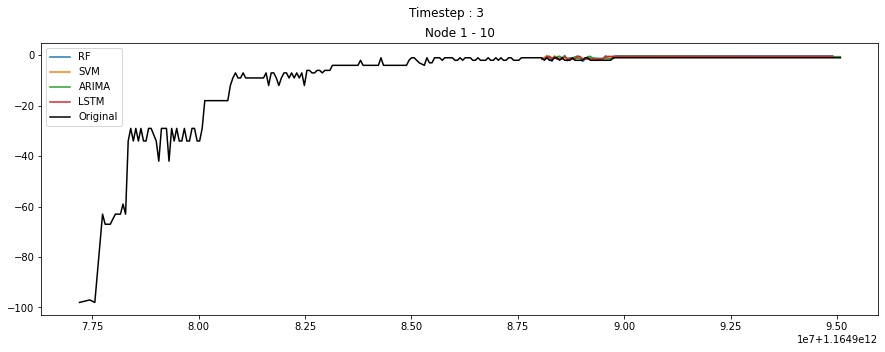

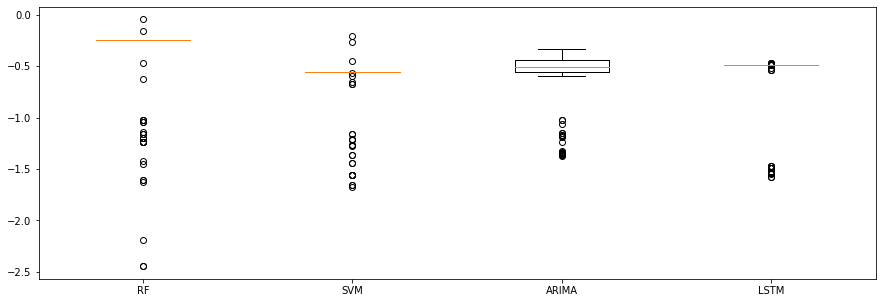

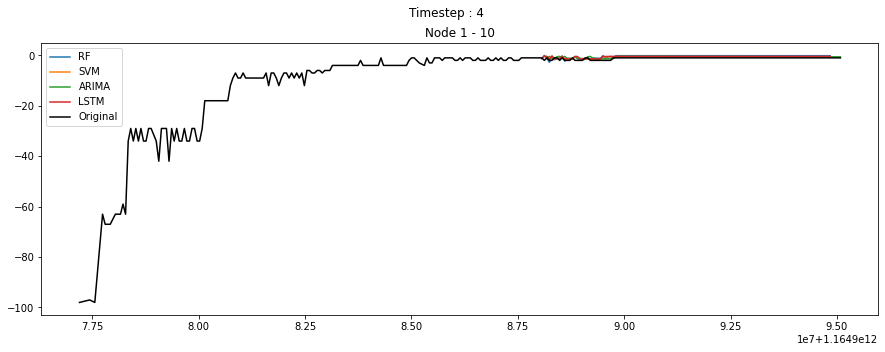

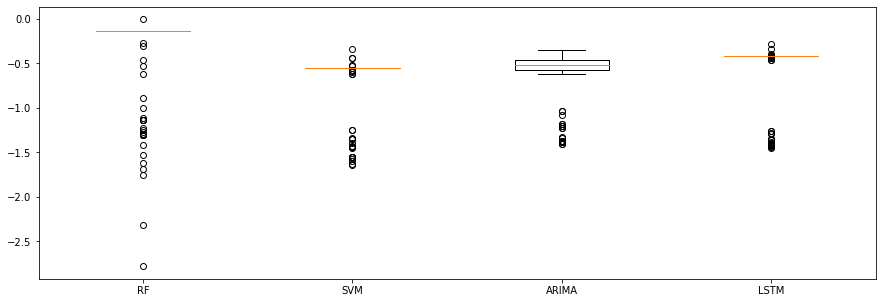

In [37]:
ejecutarModelos(True, True, path, nodeId, SrcNode, indicador, numNeuronas, epocas)